## Libraries and imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import pandas as pd
import tarfile
import cv2
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.callbacks import ModelCheckpoint
import time
import matplotlib.patches as patches
from align import AlignDlib
from keras.models import model_from_json
from keras.models import load_model

Using TensorFlow backend.


## Databases

In [2]:
ATTRS_NAME = "./data/lfw_attributes.txt"

IMAGES_NAME = "./data/lfw-deepfunneled.tgz"

RAW_IMAGES_NAME = "./data/lfw.tgz"

## Image decoder

In [3]:
def decoder(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

## Image Loader

In [4]:
def load_lfw_dataset(
        use_raw=False,
        dx=80, dy=80,
        dimx=45, dimy=45):

    # Read attrs
    df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
    df_attrs.head()
    imgs_with_attrs = set(map(tuple, df_attrs[["person", "imagenum"]].values))

    # Read photos
    all_photos = []
    photo_ids = []


    # Read attrs
    #df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
    #df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
    #df_attrs.head()
    with tarfile.open(RAW_IMAGES_NAME if use_raw else IMAGES_NAME) as f:
        for m in f.getmembers():
            # Only process image files from the compressed data
            print(m)
            if m.isfile() and m.name.endswith(".jpg"):
                # Prepare image
                img = decoder(f.extractfile(m).read())

                # Crop only faces and resize it
                img = img[dy:-dy, dx:-dx]
                img = cv2.resize(img, (dimx, dimy))

                # Parse person and append it to the collected data
                foldername = os.path.split(m.name)
                filename = os.path.split(m.name)[-1]
                fname_splitted = filename[:-4].replace('_', ' ').split()
                person_id = ' '.join(fname_splitted[:-1])
                photo_number = int(fname_splitted[-1])
                if (person_id, photo_number) in imgs_with_attrs:
                    all_photos.append(img)
                    photo_ids.append({'Person': person_id, 'imagenum': photo_number, 'Array': img, "File": filename, "Path": foldername })

    photo_ids = pd.DataFrame(photo_ids)
    all_photos = np.stack(all_photos).astype('uint8')
    all_photos = all_photos.astype('float32') / 255.0 - 0.5

    # Preserve photo_ids order!
    #all_attrs = photo_ids.merge(df_attrs, on=('person', 'imagenum'))

    return all_photos, photo_ids#all_attrs 

## Apply The Loader

In [5]:
X, photosDf = load_lfw_dataset(use_raw=True, dimx=128, dimy=128)

<TarInfo 'lfw' at 0x7fe5e534aae0>
<TarInfo 'lfw/George_HW_Bush' at 0x7fe5e534abb0>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0001.jpg' at 0x7fe5e534aa10>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0002.jpg' at 0x7fe5e534ac80>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0003.jpg' at 0x7fe5e534ad50>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0004.jpg' at 0x7fe5e534aef0>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0005.jpg' at 0x7fe5e534ae20>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0006.jpg' at 0x7fe5c679e120>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0007.jpg' at 0x7fe5c679e1f0>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0008.jpg' at 0x7fe5c679e2c0>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0009.jpg' at 0x7fe5c679e390>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0010.jpg' at 0x7fe5c679e460>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0011.jpg' at 0x7fe5c679e530>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0012.jpg' at 0x7fe5c679e600>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bu

<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0048.jpg' at 0x7fe5c67cec80>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0049.jpg' at 0x7fe5c67ced50>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0050.jpg' at 0x7fe5c67cee20>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0051.jpg' at 0x7fe5c67ceef0>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0052.jpg' at 0x7fe5c67ce120>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0053.jpg' at 0x7fe5c6752050>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0054.jpg' at 0x7fe5c67521f0>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0055.jpg' at 0x7fe5c67522c0>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0056.jpg' at 0x7fe5c6752390>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0057.jpg' at 0x7fe5c6752460>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0058.jpg' at 0x7fe5c6752530>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0059.jpg' at 0x7fe5c6752600>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_00

<TarInfo 'lfw/George_W_Bush/George_W_Bush_0008.jpg' at 0x7fe5c6780c80>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0009.jpg' at 0x7fe5c6780d50>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0010.jpg' at 0x7fe5c6780e20>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0011.jpg' at 0x7fe5c6780ef0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0012.jpg' at 0x7fe5c67807a0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0013.jpg' at 0x7fe5c6785120>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0014.jpg' at 0x7fe5c67851f0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0015.jpg' at 0x7fe5c67852c0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0016.jpg' at 0x7fe5c6785390>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0017.jpg' at 0x7fe5c6785460>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0018.jpg' at 0x7fe5c6785530>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0019.jpg' at 0x7fe5c6785600>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0020.jpg' at 0x7fe5c67856d0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0021.jpg' at 0x7fe5c67857a0>
<TarIn

<TarInfo 'lfw/George_W_Bush/George_W_Bush_0227.jpg' at 0x7fe5c6736530>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0228.jpg' at 0x7fe5c6736600>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0229.jpg' at 0x7fe5c67366d0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0230.jpg' at 0x7fe5c67367a0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0231.jpg' at 0x7fe5c6736870>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0232.jpg' at 0x7fe5c6736940>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0233.jpg' at 0x7fe5c6736a10>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0234.jpg' at 0x7fe5c6736ae0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0235.jpg' at 0x7fe5c6736bb0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0236.jpg' at 0x7fe5c6736c80>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0237.jpg' at 0x7fe5c6736d50>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0238.jpg' at 0x7fe5c6736e20>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0239.jpg' at 0x7fe5c6736ef0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0240.jpg' at 0x7fe5c6736050>
<TarIn

<TarInfo 'lfw/George_W_Bush/George_W_Bush_0445.jpg' at 0x7fe5c66e4c80>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0446.jpg' at 0x7fe5c66e4d50>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0447.jpg' at 0x7fe5c66e4e20>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0448.jpg' at 0x7fe5c66e4ef0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0449.jpg' at 0x7fe5c66e4050>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0450.jpg' at 0x7fe5c66e8120>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0451.jpg' at 0x7fe5c66e81f0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0452.jpg' at 0x7fe5c66e82c0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0453.jpg' at 0x7fe5c66e8390>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0454.jpg' at 0x7fe5c66e8460>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0455.jpg' at 0x7fe5c66e8530>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0456.jpg' at 0x7fe5c66e8600>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0457.jpg' at 0x7fe5c66e86d0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0458.jpg' at 0x7fe5c66e87a0>
<TarIn

<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0026.jpg' at 0x7fe5c669bae0>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0027.jpg' at 0x7fe5c669bbb0>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0028.jpg' at 0x7fe5c669bc80>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0029.jpg' at 0x7fe5c669bd50>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0030.jpg' at 0x7fe5c669be20>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0031.jpg' at 0x7fe5c669bef0>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0032.jpg' at 0x7fe5c669b050>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0033.jpg' at 0x7fe5c66a1120>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0034.jpg' at 0x7fe5c66a11f0>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0035.jpg' at 0x7fe5c66a12c0>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0036.jpg' at 0x7fe5c66a1390>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0037.jpg' at 0x7fe5c66a1460>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0038.jpg' at 0x7fe5c66a1530>
<TarInfo 'lfw/Donald_Rums

<TarInfo 'lfw/Lance_Armstrong/Lance_Armstrong_0015.jpg' at 0x7fe5c66501f0>
<TarInfo 'lfw/Lance_Armstrong/Lance_Armstrong_0016.jpg' at 0x7fe5c66502c0>
<TarInfo 'lfw/Lance_Armstrong/Lance_Armstrong_0017.jpg' at 0x7fe5c6650390>
<TarInfo 'lfw/Lance_Armstrong/Lance_Armstrong_0018.jpg' at 0x7fe5c6650460>
<TarInfo 'lfw/Ted_Washington' at 0x7fe5c6650530>
<TarInfo 'lfw/Ted_Washington/Ted_Washington_0001.jpg' at 0x7fe5c6650600>
<TarInfo 'lfw/Stephen_Push' at 0x7fe5c6650050>
<TarInfo 'lfw/Stephen_Push/Stephen_Push_0001.jpg' at 0x7fe5c66507a0>
<TarInfo 'lfw/Lleyton_Hewitt' at 0x7fe5c66506d0>
<TarInfo 'lfw/Lleyton_Hewitt/Lleyton_Hewitt_0001.jpg' at 0x7fe5c6650940>
<TarInfo 'lfw/Lleyton_Hewitt/Lleyton_Hewitt_0002.jpg' at 0x7fe5c6650870>
<TarInfo 'lfw/Lleyton_Hewitt/Lleyton_Hewitt_0003.jpg' at 0x7fe5c6650a10>
<TarInfo 'lfw/Lleyton_Hewitt/Lleyton_Hewitt_0004.jpg' at 0x7fe5c6650c80>
<TarInfo 'lfw/Lleyton_Hewitt/Lleyton_Hewitt_0005.jpg' at 0x7fe5c6650ae0>
<TarInfo 'lfw/Lleyton_Hewitt/Lleyton_Hewitt_0006

<TarInfo 'lfw/Atal_Bihari_Vajpayee/Atal_Bihari_Vajpayee_0002.jpg' at 0x7fe5c6684050>
<TarInfo 'lfw/Atal_Bihari_Vajpayee/Atal_Bihari_Vajpayee_0003.jpg' at 0x7fe5c66846d0>
<TarInfo 'lfw/Atal_Bihari_Vajpayee/Atal_Bihari_Vajpayee_0004.jpg' at 0x7fe5c66847a0>
<TarInfo 'lfw/Atal_Bihari_Vajpayee/Atal_Bihari_Vajpayee_0005.jpg' at 0x7fe5c6684870>
<TarInfo 'lfw/Atal_Bihari_Vajpayee/Atal_Bihari_Vajpayee_0006.jpg' at 0x7fe5c6684940>
<TarInfo 'lfw/Atal_Bihari_Vajpayee/Atal_Bihari_Vajpayee_0007.jpg' at 0x7fe5c6684a10>
<TarInfo 'lfw/Atal_Bihari_Vajpayee/Atal_Bihari_Vajpayee_0008.jpg' at 0x7fe5c6684ae0>
<TarInfo 'lfw/Atal_Bihari_Vajpayee/Atal_Bihari_Vajpayee_0009.jpg' at 0x7fe5c6684bb0>
<TarInfo 'lfw/Atal_Bihari_Vajpayee/Atal_Bihari_Vajpayee_0010.jpg' at 0x7fe5c6684c80>
<TarInfo 'lfw/Atal_Bihari_Vajpayee/Atal_Bihari_Vajpayee_0011.jpg' at 0x7fe5c6684d50>
<TarInfo 'lfw/Atal_Bihari_Vajpayee/Atal_Bihari_Vajpayee_0012.jpg' at 0x7fe5c6684e20>
<TarInfo 'lfw/Atal_Bihari_Vajpayee/Atal_Bihari_Vajpayee_0013.jpg'

<TarInfo 'lfw/Sophia_Loren/Sophia_Loren_0006.jpg' at 0x7fe5c6636600>
<TarInfo 'lfw/Sophia_Loren/Sophia_Loren_0007.jpg' at 0x7fe5c66366d0>
<TarInfo 'lfw/Noelle_Bush' at 0x7fe5c66367a0>
<TarInfo 'lfw/Noelle_Bush/Noelle_Bush_0001.jpg' at 0x7fe5c6636870>
<TarInfo 'lfw/Noelle_Bush/Noelle_Bush_0002.jpg' at 0x7fe5c66362c0>
<TarInfo 'lfw/Noelle_Bush/Noelle_Bush_0003.jpg' at 0x7fe5c6636a10>
<TarInfo 'lfw/Noelle_Bush/Noelle_Bush_0004.jpg' at 0x7fe5c6636ae0>
<TarInfo 'lfw/Emmanuel_Milingo' at 0x7fe5c6636bb0>
<TarInfo 'lfw/Emmanuel_Milingo/Emmanuel_Milingo_0001.jpg' at 0x7fe5c6636c80>
<TarInfo 'lfw/Tony_Blair' at 0x7fe5c6636940>
<TarInfo 'lfw/Tony_Blair/Tony_Blair_0001.jpg' at 0x7fe5c6636e20>
<TarInfo 'lfw/Tony_Blair/Tony_Blair_0002.jpg' at 0x7fe5c6636d50>
<TarInfo 'lfw/Tony_Blair/Tony_Blair_0003.jpg' at 0x7fe5c6636ef0>
<TarInfo 'lfw/Tony_Blair/Tony_Blair_0004.jpg' at 0x7fe5c663c050>
<TarInfo 'lfw/Tony_Blair/Tony_Blair_0005.jpg' at 0x7fe5c663c1f0>
<TarInfo 'lfw/Tony_Blair/Tony_Blair_0006.jpg' at 0

<TarInfo 'lfw/Megawati_Sukarnoputri/Megawati_Sukarnoputri_0018.jpg' at 0x7fe5c65ecae0>
<TarInfo 'lfw/Megawati_Sukarnoputri/Megawati_Sukarnoputri_0019.jpg' at 0x7fe5c65ecbb0>
<TarInfo 'lfw/Megawati_Sukarnoputri/Megawati_Sukarnoputri_0020.jpg' at 0x7fe5c65ecc80>
<TarInfo 'lfw/Megawati_Sukarnoputri/Megawati_Sukarnoputri_0021.jpg' at 0x7fe5c65ecd50>
<TarInfo 'lfw/Megawati_Sukarnoputri/Megawati_Sukarnoputri_0022.jpg' at 0x7fe5c65ece20>
<TarInfo 'lfw/Megawati_Sukarnoputri/Megawati_Sukarnoputri_0023.jpg' at 0x7fe5c65ecef0>
<TarInfo 'lfw/Megawati_Sukarnoputri/Megawati_Sukarnoputri_0024.jpg' at 0x7fe5c65ec120>
<TarInfo 'lfw/Megawati_Sukarnoputri/Megawati_Sukarnoputri_0025.jpg' at 0x7fe5c65ee050>
<TarInfo 'lfw/Megawati_Sukarnoputri/Megawati_Sukarnoputri_0026.jpg' at 0x7fe5c65ee1f0>
<TarInfo 'lfw/Megawati_Sukarnoputri/Megawati_Sukarnoputri_0027.jpg' at 0x7fe5c65ee2c0>
<TarInfo 'lfw/Megawati_Sukarnoputri/Megawati_Sukarnoputri_0028.jpg' at 0x7fe5c65ee390>
<TarInfo 'lfw/Megawati_Sukarnoputri/Megawat

<TarInfo 'lfw/Colin_Powell/Colin_Powell_0049.jpg' at 0x7fe5c659fef0>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0050.jpg' at 0x7fe5c659f120>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0051.jpg' at 0x7fe5c65a2120>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0052.jpg' at 0x7fe5c65a21f0>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0053.jpg' at 0x7fe5c65a22c0>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0054.jpg' at 0x7fe5c65a2390>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0055.jpg' at 0x7fe5c65a2460>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0056.jpg' at 0x7fe5c65a2530>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0057.jpg' at 0x7fe5c65a2600>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0058.jpg' at 0x7fe5c65a26d0>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0059.jpg' at 0x7fe5c65a27a0>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0060.jpg' at 0x7fe5c65a2870>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0061.jpg' at 0x7fe5c65a2940>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0062.jpg' at 0x7fe5c65a2a10>
<TarInfo 'lfw/Colin_Powell/Colin_P

<TarInfo 'lfw/Laura_Bush/Laura_Bush_0007.jpg' at 0x7fe5c654f390>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0008.jpg' at 0x7fe5c654f460>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0009.jpg' at 0x7fe5c654f530>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0010.jpg' at 0x7fe5c654f600>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0011.jpg' at 0x7fe5c654f6d0>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0012.jpg' at 0x7fe5c654f7a0>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0013.jpg' at 0x7fe5c654f870>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0014.jpg' at 0x7fe5c654f940>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0015.jpg' at 0x7fe5c654fa10>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0016.jpg' at 0x7fe5c654fae0>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0017.jpg' at 0x7fe5c654fbb0>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0018.jpg' at 0x7fe5c654fc80>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0019.jpg' at 0x7fe5c654fd50>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0020.jpg' at 0x7fe5c654fe20>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0021.jpg' at 0x7fe5c654fef0>
<TarInfo 'lfw/Laura_Bush/

<TarInfo 'lfw/Serena_Williams/Serena_Williams_0020.jpg' at 0x7fe5c6581390>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0021.jpg' at 0x7fe5c6581460>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0022.jpg' at 0x7fe5c6581530>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0023.jpg' at 0x7fe5c6581600>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0024.jpg' at 0x7fe5c65816d0>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0025.jpg' at 0x7fe5c65817a0>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0026.jpg' at 0x7fe5c6581870>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0027.jpg' at 0x7fe5c6581940>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0028.jpg' at 0x7fe5c6581a10>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0029.jpg' at 0x7fe5c6581ae0>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0030.jpg' at 0x7fe5c6581bb0>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0031.jpg' at 0x7fe5c6581c80>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0032.jpg' at 0x7fe5c6581d50>
<TarInfo 'lfw/Serena_Will

<TarInfo 'lfw/Taha_Yassin_Ramadan/Taha_Yassin_Ramadan_0002.jpg' at 0x7fe5c6527870>
<TarInfo 'lfw/Taha_Yassin_Ramadan/Taha_Yassin_Ramadan_0003.jpg' at 0x7fe5c6527ae0>
<TarInfo 'lfw/Taha_Yassin_Ramadan/Taha_Yassin_Ramadan_0004.jpg' at 0x7fe5c6527bb0>
<TarInfo 'lfw/Taha_Yassin_Ramadan/Taha_Yassin_Ramadan_0005.jpg' at 0x7fe5c6527c80>
<TarInfo 'lfw/Taha_Yassin_Ramadan/Taha_Yassin_Ramadan_0006.jpg' at 0x7fe5c6527d50>
<TarInfo 'lfw/Taha_Yassin_Ramadan/Taha_Yassin_Ramadan_0007.jpg' at 0x7fe5c6527e20>
<TarInfo 'lfw/Taha_Yassin_Ramadan/Taha_Yassin_Ramadan_0008.jpg' at 0x7fe5c6527ef0>
<TarInfo 'lfw/Taha_Yassin_Ramadan/Taha_Yassin_Ramadan_0009.jpg' at 0x7fe5c6527a10>
<TarInfo 'lfw/Taha_Yassin_Ramadan/Taha_Yassin_Ramadan_0010.jpg' at 0x7fe5c652b120>
<TarInfo 'lfw/Taha_Yassin_Ramadan/Taha_Yassin_Ramadan_0011.jpg' at 0x7fe5c652b1f0>
<TarInfo 'lfw/Taha_Yassin_Ramadan/Taha_Yassin_Ramadan_0012.jpg' at 0x7fe5c652b2c0>
<TarInfo 'lfw/Taha_Yassin_Ramadan/Taha_Yassin_Ramadan_0013.jpg' at 0x7fe5c652b390>
<Tar

<TarInfo 'lfw/Jean-Pierre_Raffarin/Jean-Pierre_Raffarin_0005.jpg' at 0x7fe5c64e0e20>
<TarInfo 'lfw/Jean-Pierre_Raffarin/Jean-Pierre_Raffarin_0006.jpg' at 0x7fe5c64e0ef0>
<TarInfo 'lfw/Jean-Pierre_Raffarin/Jean-Pierre_Raffarin_0007.jpg' at 0x7fe5c64e0bb0>
<TarInfo 'lfw/Horace_Newcomb' at 0x7fe5c64e4050>
<TarInfo 'lfw/Horace_Newcomb/Horace_Newcomb_0001.jpg' at 0x7fe5c64e41f0>
<TarInfo 'lfw/Priscilla_Presley' at 0x7fe5c64e4120>
<TarInfo 'lfw/Priscilla_Presley/Priscilla_Presley_0001.jpg' at 0x7fe5c64e4390>
<TarInfo 'lfw/Priscilla_Presley/Priscilla_Presley_0002.jpg' at 0x7fe5c64e42c0>
<TarInfo 'lfw/Penelope_Cruz' at 0x7fe5c64e4530>
<TarInfo 'lfw/Penelope_Cruz/Penelope_Cruz_0001.jpg' at 0x7fe5c64e4600>
<TarInfo 'lfw/Penelope_Cruz/Penelope_Cruz_0002.jpg' at 0x7fe5c64e4460>
<TarInfo 'lfw/Penelope_Cruz/Penelope_Cruz_0003.jpg' at 0x7fe5c64e47a0>
<TarInfo 'lfw/Karen_Lynn_Gorney' at 0x7fe5c64e4870>
<TarInfo 'lfw/Karen_Lynn_Gorney/Karen_Lynn_Gorney_0001.jpg' at 0x7fe5c64e4940>
<TarInfo 'lfw/Mike_We

<TarInfo 'lfw/Robert_Redford/Robert_Redford_0006.jpg' at 0x7fe5c649ac80>
<TarInfo 'lfw/Robert_Redford/Robert_Redford_0007.jpg' at 0x7fe5c649ad50>
<TarInfo 'lfw/Robert_Redford/Robert_Redford_0008.jpg' at 0x7fe5c649ae20>
<TarInfo 'lfw/Miles_Stewart' at 0x7fe5c649aef0>
<TarInfo 'lfw/Miles_Stewart/Miles_Stewart_0001.jpg' at 0x7fe5c649a940>
<TarInfo 'lfw/Spencer_Abraham' at 0x7fe5c649f050>
<TarInfo 'lfw/Spencer_Abraham/Spencer_Abraham_0001.jpg' at 0x7fe5c649f1f0>
<TarInfo 'lfw/Spencer_Abraham/Spencer_Abraham_0002.jpg' at 0x7fe5c649f120>
<TarInfo 'lfw/Spencer_Abraham/Spencer_Abraham_0003.jpg' at 0x7fe5c649f390>
<TarInfo 'lfw/Spencer_Abraham/Spencer_Abraham_0004.jpg' at 0x7fe5c649f460>
<TarInfo 'lfw/Spencer_Abraham/Spencer_Abraham_0005.jpg' at 0x7fe5c649f530>
<TarInfo 'lfw/Spencer_Abraham/Spencer_Abraham_0006.jpg' at 0x7fe5c649f600>
<TarInfo 'lfw/Spencer_Abraham/Spencer_Abraham_0007.jpg' at 0x7fe5c649f6d0>
<TarInfo 'lfw/Spencer_Abraham/Spencer_Abraham_0008.jpg' at 0x7fe5c649f7a0>
<TarInfo 'lf

<TarInfo 'lfw/Anders_Fogh_Rasmussen/Anders_Fogh_Rasmussen_0002.jpg' at 0x7fe5c6458120>
<TarInfo 'lfw/Anders_Fogh_Rasmussen/Anders_Fogh_Rasmussen_0003.jpg' at 0x7fe5c64586d0>
<TarInfo 'lfw/Anders_Fogh_Rasmussen/Anders_Fogh_Rasmussen_0004.jpg' at 0x7fe5c64587a0>
<TarInfo 'lfw/Gustavo_Kuerten' at 0x7fe5c6458870>
<TarInfo 'lfw/Gustavo_Kuerten/Gustavo_Kuerten_0001.jpg' at 0x7fe5c6458940>
<TarInfo 'lfw/Gustavo_Kuerten/Gustavo_Kuerten_0002.jpg' at 0x7fe5c6458600>
<TarInfo 'lfw/Gustavo_Kuerten/Gustavo_Kuerten_0003.jpg' at 0x7fe5c6458ae0>
<TarInfo 'lfw/Monica_Seles' at 0x7fe5c6458bb0>
<TarInfo 'lfw/Monica_Seles/Monica_Seles_0001.jpg' at 0x7fe5c6458c80>
<TarInfo 'lfw/Monica_Seles/Monica_Seles_0002.jpg' at 0x7fe5c6458a10>
<TarInfo 'lfw/Monica_Seles/Monica_Seles_0003.jpg' at 0x7fe5c6458e20>
<TarInfo 'lfw/Monica_Seles/Monica_Seles_0004.jpg' at 0x7fe5c6458ef0>
<TarInfo 'lfw/Monica_Seles/Monica_Seles_0005.jpg' at 0x7fe5c6458d50>
<TarInfo 'lfw/Monica_Seles/Monica_Seles_0006.jpg' at 0x7fe5c645b050>
<Ta

<TarInfo 'lfw/Marat_Safin/Marat_Safin_0003.jpg' at 0x7fe5c648bae0>
<TarInfo 'lfw/Gabrielle_Rose' at 0x7fe5c648bbb0>
<TarInfo 'lfw/Gabrielle_Rose/Gabrielle_Rose_0001.jpg' at 0x7fe5c648bc80>
<TarInfo 'lfw/Tomoko_Hagiwara' at 0x7fe5c648ba10>
<TarInfo 'lfw/Tomoko_Hagiwara/Tomoko_Hagiwara_0001.jpg' at 0x7fe5c648be20>
<TarInfo 'lfw/Tomoko_Hagiwara/Tomoko_Hagiwara_0002.jpg' at 0x7fe5c648bd50>
<TarInfo 'lfw/John_Wayne' at 0x7fe5c648bef0>
<TarInfo 'lfw/John_Wayne/John_Wayne_0001.jpg' at 0x7fe5c640f050>
<TarInfo 'lfw/Juan_Carlos_Ferrero' at 0x7fe5c640f120>
<TarInfo 'lfw/Juan_Carlos_Ferrero/Juan_Carlos_Ferrero_0001.jpg' at 0x7fe5c640f2c0>
<TarInfo 'lfw/Juan_Carlos_Ferrero/Juan_Carlos_Ferrero_0002.jpg' at 0x7fe5c640f1f0>
<TarInfo 'lfw/Juan_Carlos_Ferrero/Juan_Carlos_Ferrero_0003.jpg' at 0x7fe5c640f460>
<TarInfo 'lfw/Juan_Carlos_Ferrero/Juan_Carlos_Ferrero_0004.jpg' at 0x7fe5c640f530>
<TarInfo 'lfw/Juan_Carlos_Ferrero/Juan_Carlos_Ferrero_0005.jpg' at 0x7fe5c640f600>
<TarInfo 'lfw/Juan_Carlos_Ferrer

<TarInfo 'lfw/Hu_Jintao/Hu_Jintao_0009.jpg' at 0x7fe5c6439d50>
<TarInfo 'lfw/Hu_Jintao/Hu_Jintao_0010.jpg' at 0x7fe5c6439e20>
<TarInfo 'lfw/Hu_Jintao/Hu_Jintao_0011.jpg' at 0x7fe5c6439ef0>
<TarInfo 'lfw/Hu_Jintao/Hu_Jintao_0012.jpg' at 0x7fe5c64397a0>
<TarInfo 'lfw/Hu_Jintao/Hu_Jintao_0013.jpg' at 0x7fe5c643e050>
<TarInfo 'lfw/Hu_Jintao/Hu_Jintao_0014.jpg' at 0x7fe5c643e1f0>
<TarInfo 'lfw/Hu_Jintao/Hu_Jintao_0015.jpg' at 0x7fe5c643e2c0>
<TarInfo 'lfw/Lindsay_Davenport' at 0x7fe5c643e390>
<TarInfo 'lfw/Lindsay_Davenport/Lindsay_Davenport_0001.jpg' at 0x7fe5c643e460>
<TarInfo 'lfw/Lindsay_Davenport/Lindsay_Davenport_0002.jpg' at 0x7fe5c643e120>
<TarInfo 'lfw/Lindsay_Davenport/Lindsay_Davenport_0003.jpg' at 0x7fe5c643e600>
<TarInfo 'lfw/Lindsay_Davenport/Lindsay_Davenport_0004.jpg' at 0x7fe5c643e6d0>
<TarInfo 'lfw/Lindsay_Davenport/Lindsay_Davenport_0005.jpg' at 0x7fe5c643e7a0>
<TarInfo 'lfw/Lindsay_Davenport/Lindsay_Davenport_0006.jpg' at 0x7fe5c643e870>
<TarInfo 'lfw/Lindsay_Davenport/L

<TarInfo 'lfw/Alec_Baldwin' at 0x7fe5c63eda10>
<TarInfo 'lfw/Alec_Baldwin/Alec_Baldwin_0001.jpg' at 0x7fe5c63edae0>
<TarInfo 'lfw/Alec_Baldwin/Alec_Baldwin_0002.jpg' at 0x7fe5c63ed940>
<TarInfo 'lfw/Alec_Baldwin/Alec_Baldwin_0003.jpg' at 0x7fe5c63edc80>
<TarInfo 'lfw/Alec_Baldwin/Alec_Baldwin_0004.jpg' at 0x7fe5c63edd50>
<TarInfo 'lfw/Kristin_Davis' at 0x7fe5c63ede20>
<TarInfo 'lfw/Kristin_Davis/Kristin_Davis_0001.jpg' at 0x7fe5c63edef0>
<TarInfo 'lfw/Kristin_Davis/Kristin_Davis_0002.jpg' at 0x7fe5c63edbb0>
<TarInfo 'lfw/Kristin_Davis/Kristin_Davis_0003.jpg' at 0x7fe5c63f2120>
<TarInfo 'lfw/Daniel_Zelman' at 0x7fe5c63f21f0>
<TarInfo 'lfw/Daniel_Zelman/Daniel_Zelman_0001.jpg' at 0x7fe5c63f22c0>
<TarInfo 'lfw/John_Spencer' at 0x7fe5c63f2050>
<TarInfo 'lfw/John_Spencer/John_Spencer_0001.jpg' at 0x7fe5c63f2460>
<TarInfo 'lfw/John_Spencer/John_Spencer_0002.jpg' at 0x7fe5c63f2390>
<TarInfo 'lfw/Laura_Linney' at 0x7fe5c63f2600>
<TarInfo 'lfw/Laura_Linney/Laura_Linney_0001.jpg' at 0x7fe5c63f26

<TarInfo 'lfw/Nicole_Kidman/Nicole_Kidman_0014.jpg' at 0x7fe5c63ae390>
<TarInfo 'lfw/Nicole_Kidman/Nicole_Kidman_0015.jpg' at 0x7fe5c63ae460>
<TarInfo 'lfw/Nicole_Kidman/Nicole_Kidman_0016.jpg' at 0x7fe5c63ae530>
<TarInfo 'lfw/Nicole_Kidman/Nicole_Kidman_0017.jpg' at 0x7fe5c63ae600>
<TarInfo 'lfw/Nicole_Kidman/Nicole_Kidman_0018.jpg' at 0x7fe5c63ae6d0>
<TarInfo 'lfw/Nicole_Kidman/Nicole_Kidman_0019.jpg' at 0x7fe5c63ae7a0>
<TarInfo 'lfw/George_Harrison' at 0x7fe5c63ae870>
<TarInfo 'lfw/George_Harrison/George_Harrison_0001.jpg' at 0x7fe5c63ae940>
<TarInfo 'lfw/Ellen_Saracini' at 0x7fe5c63ae050>
<TarInfo 'lfw/Ellen_Saracini/Ellen_Saracini_0001.jpg' at 0x7fe5c63aeae0>
<TarInfo 'lfw/Paul_Brandt' at 0x7fe5c63aea10>
<TarInfo 'lfw/Paul_Brandt/Paul_Brandt_0001.jpg' at 0x7fe5c63aec80>
<TarInfo 'lfw/Rachel_Griffiths' at 0x7fe5c63aebb0>
<TarInfo 'lfw/Rachel_Griffiths/Rachel_Griffiths_0001.jpg' at 0x7fe5c63aee20>
<TarInfo 'lfw/Rachel_Griffiths/Rachel_Griffiths_0002.jpg' at 0x7fe5c63aed50>
<TarInfo 

<TarInfo 'lfw/Julia_Tymoshenko' at 0x7fe5c6368050>
<TarInfo 'lfw/Julia_Tymoshenko/Julia_Tymoshenko_0001.jpg' at 0x7fe5c63682c0>
<TarInfo 'lfw/Julia_Tymoshenko/Julia_Tymoshenko_0002.jpg' at 0x7fe5c63681f0>
<TarInfo 'lfw/Julia_Tymoshenko/Julia_Tymoshenko_0003.jpg' at 0x7fe5c6368460>
<TarInfo 'lfw/Brian_Cashman' at 0x7fe5c6368530>
<TarInfo 'lfw/Brian_Cashman/Brian_Cashman_0001.jpg' at 0x7fe5c6368600>
<TarInfo 'lfw/Joe_Plumeri' at 0x7fe5c6368390>
<TarInfo 'lfw/Joe_Plumeri/Joe_Plumeri_0001.jpg' at 0x7fe5c63687a0>
<TarInfo 'lfw/Milt_Palacio' at 0x7fe5c63686d0>
<TarInfo 'lfw/Milt_Palacio/Milt_Palacio_0001.jpg' at 0x7fe5c6368940>
<TarInfo 'lfw/Ellen_Barkin' at 0x7fe5c6368870>
<TarInfo 'lfw/Ellen_Barkin/Ellen_Barkin_0001.jpg' at 0x7fe5c6368ae0>
<TarInfo 'lfw/Bob_Geldof' at 0x7fe5c6368a10>
<TarInfo 'lfw/Bob_Geldof/Bob_Geldof_0001.jpg' at 0x7fe5c6368c80>
<TarInfo 'lfw/Bob_Geldof/Bob_Geldof_0002.jpg' at 0x7fe5c6368bb0>
<TarInfo 'lfw/Nicole' at 0x7fe5c6368e20>
<TarInfo 'lfw/Nicole/Nicole_0001.jpg' 

<TarInfo 'lfw/Heidi_Klum/Heidi_Klum_0003.jpg' at 0x7fe5c6324d50>
<TarInfo 'lfw/Heidi_Klum/Heidi_Klum_0004.jpg' at 0x7fe5c6324e20>
<TarInfo 'lfw/Heidi_Klum/Heidi_Klum_0005.jpg' at 0x7fe5c6324ef0>
<TarInfo 'lfw/Art_Cooper' at 0x7fe5c6324c80>
<TarInfo 'lfw/Art_Cooper/Art_Cooper_0001.jpg' at 0x7fe5c6328120>
<TarInfo 'lfw/Robert_Evans' at 0x7fe5c6328050>
<TarInfo 'lfw/Robert_Evans/Robert_Evans_0001.jpg' at 0x7fe5c63282c0>
<TarInfo 'lfw/Robert_Evans/Robert_Evans_0002.jpg' at 0x7fe5c63281f0>
<TarInfo 'lfw/Robert_Evans/Robert_Evans_0003.jpg' at 0x7fe5c6328460>
<TarInfo 'lfw/John_Burnett' at 0x7fe5c6328530>
<TarInfo 'lfw/John_Burnett/John_Burnett_0001.jpg' at 0x7fe5c6328600>
<TarInfo 'lfw/Sean_Penn' at 0x7fe5c6328390>
<TarInfo 'lfw/Sean_Penn/Sean_Penn_0001.jpg' at 0x7fe5c63287a0>
<TarInfo 'lfw/Sean_Penn/Sean_Penn_0002.jpg' at 0x7fe5c63286d0>
<TarInfo 'lfw/Sean_Penn/Sean_Penn_0003.jpg' at 0x7fe5c6328940>
<TarInfo 'lfw/Enrica_Fico' at 0x7fe5c6328a10>
<TarInfo 'lfw/Enrica_Fico/Enrica_Fico_0001.jpg

<TarInfo 'lfw/Colin_Farrell/Colin_Farrell_0002.jpg' at 0x7fe5c62e67a0>
<TarInfo 'lfw/Colin_Farrell/Colin_Farrell_0003.jpg' at 0x7fe5c62e6a10>
<TarInfo 'lfw/Colin_Farrell/Colin_Farrell_0004.jpg' at 0x7fe5c62e6ae0>
<TarInfo 'lfw/Colin_Farrell/Colin_Farrell_0005.jpg' at 0x7fe5c62e6bb0>
<TarInfo 'lfw/Colin_Farrell/Colin_Farrell_0006.jpg' at 0x7fe5c62e6c80>
<TarInfo 'lfw/Colin_Farrell/Colin_Farrell_0007.jpg' at 0x7fe5c62e6d50>
<TarInfo 'lfw/Colin_Farrell/Colin_Farrell_0008.jpg' at 0x7fe5c62e6e20>
<TarInfo 'lfw/Colin_Farrell/Colin_Farrell_0009.jpg' at 0x7fe5c62e6ef0>
<TarInfo 'lfw/Jane_Walker_Wood' at 0x7fe5c62e6940>
<TarInfo 'lfw/Jane_Walker_Wood/Jane_Walker_Wood_0001.jpg' at 0x7fe5c62e8120>
<TarInfo 'lfw/Kay_Bailey_Hutchison' at 0x7fe5c62e8050>
<TarInfo 'lfw/Kay_Bailey_Hutchison/Kay_Bailey_Hutchison_0001.jpg' at 0x7fe5c62e82c0>
<TarInfo 'lfw/Afton_Smith' at 0x7fe5c62e81f0>
<TarInfo 'lfw/Afton_Smith/Afton_Smith_0001.jpg' at 0x7fe5c62e8460>
<TarInfo 'lfw/Brendan_Fraser' at 0x7fe5c62e8390>
<T

<TarInfo 'lfw/Jennifer_Lopez/Jennifer_Lopez_0008.jpg' at 0x7fe5c62a4870>
<TarInfo 'lfw/Jennifer_Lopez/Jennifer_Lopez_0009.jpg' at 0x7fe5c62a4940>
<TarInfo 'lfw/Jennifer_Lopez/Jennifer_Lopez_0010.jpg' at 0x7fe5c62a4a10>
<TarInfo 'lfw/Jennifer_Lopez/Jennifer_Lopez_0011.jpg' at 0x7fe5c62a4ae0>
<TarInfo 'lfw/Jennifer_Lopez/Jennifer_Lopez_0012.jpg' at 0x7fe5c62a4bb0>
<TarInfo 'lfw/Jennifer_Lopez/Jennifer_Lopez_0013.jpg' at 0x7fe5c62a4c80>
<TarInfo 'lfw/Jennifer_Lopez/Jennifer_Lopez_0014.jpg' at 0x7fe5c62a4d50>
<TarInfo 'lfw/Jennifer_Lopez/Jennifer_Lopez_0015.jpg' at 0x7fe5c62a4e20>
<TarInfo 'lfw/Jennifer_Lopez/Jennifer_Lopez_0016.jpg' at 0x7fe5c62a4ef0>
<TarInfo 'lfw/Jennifer_Lopez/Jennifer_Lopez_0017.jpg' at 0x7fe5c62a4390>
<TarInfo 'lfw/Jennifer_Lopez/Jennifer_Lopez_0018.jpg' at 0x7fe5c62a8120>
<TarInfo 'lfw/Jennifer_Lopez/Jennifer_Lopez_0019.jpg' at 0x7fe5c62a81f0>
<TarInfo 'lfw/Jennifer_Lopez/Jennifer_Lopez_0020.jpg' at 0x7fe5c62a82c0>
<TarInfo 'lfw/Jennifer_Lopez/Jennifer_Lopez_0021.jp

<TarInfo 'lfw/Eric_Hinske' at 0x7fe5c6260120>
<TarInfo 'lfw/Eric_Hinske/Eric_Hinske_0001.jpg' at 0x7fe5c62602c0>
<TarInfo 'lfw/Eric_Hinske/Eric_Hinske_0002.jpg' at 0x7fe5c62601f0>
<TarInfo 'lfw/Tim_Henman' at 0x7fe5c6260460>
<TarInfo 'lfw/Tim_Henman/Tim_Henman_0001.jpg' at 0x7fe5c6260530>
<TarInfo 'lfw/Tim_Henman/Tim_Henman_0002.jpg' at 0x7fe5c6260390>
<TarInfo 'lfw/Tim_Henman/Tim_Henman_0003.jpg' at 0x7fe5c62606d0>
<TarInfo 'lfw/Tim_Henman/Tim_Henman_0004.jpg' at 0x7fe5c62607a0>
<TarInfo 'lfw/Tim_Henman/Tim_Henman_0005.jpg' at 0x7fe5c6260870>
<TarInfo 'lfw/Tim_Henman/Tim_Henman_0006.jpg' at 0x7fe5c6260940>
<TarInfo 'lfw/Tim_Henman/Tim_Henman_0007.jpg' at 0x7fe5c6260a10>
<TarInfo 'lfw/Tim_Henman/Tim_Henman_0008.jpg' at 0x7fe5c6260ae0>
<TarInfo 'lfw/Tim_Henman/Tim_Henman_0009.jpg' at 0x7fe5c6260bb0>
<TarInfo 'lfw/Tim_Henman/Tim_Henman_0010.jpg' at 0x7fe5c6260c80>
<TarInfo 'lfw/Tim_Henman/Tim_Henman_0011.jpg' at 0x7fe5c6260d50>
<TarInfo 'lfw/Tim_Henman/Tim_Henman_0012.jpg' at 0x7fe5c6260

<TarInfo 'lfw/Howard_Dean/Howard_Dean_0004.jpg' at 0x7fe5c621bd50>
<TarInfo 'lfw/Howard_Dean/Howard_Dean_0005.jpg' at 0x7fe5c621be20>
<TarInfo 'lfw/Howard_Dean/Howard_Dean_0006.jpg' at 0x7fe5c621bef0>
<TarInfo 'lfw/Howard_Dean/Howard_Dean_0007.jpg' at 0x7fe5c621bbb0>
<TarInfo 'lfw/Howard_Dean/Howard_Dean_0008.jpg' at 0x7fe5c6220120>
<TarInfo 'lfw/Howard_Dean/Howard_Dean_0009.jpg' at 0x7fe5c62201f0>
<TarInfo 'lfw/Howard_Dean/Howard_Dean_0010.jpg' at 0x7fe5c6220050>
<TarInfo 'lfw/Howard_Dean/Howard_Dean_0011.jpg' at 0x7fe5c6220460>
<TarInfo 'lfw/Howard_Dean/Howard_Dean_0012.jpg' at 0x7fe5c62202c0>
<TarInfo 'lfw/Ernie_Els' at 0x7fe5c6220530>
<TarInfo 'lfw/Ernie_Els/Ernie_Els_0001.jpg' at 0x7fe5c6220600>
<TarInfo 'lfw/Ernie_Els/Ernie_Els_0002.jpg' at 0x7fe5c6220390>
<TarInfo 'lfw/Ernie_Els/Ernie_Els_0003.jpg' at 0x7fe5c62207a0>
<TarInfo 'lfw/Ernie_Els/Ernie_Els_0004.jpg' at 0x7fe5c6220870>
<TarInfo 'lfw/Meghann_Shaughnessy' at 0x7fe5c6220940>
<TarInfo 'lfw/Meghann_Shaughnessy/Meghann_Shaug

<TarInfo 'lfw/Paul_Burrell' at 0x7fe5c61de2c0>
<TarInfo 'lfw/Paul_Burrell/Paul_Burrell_0001.jpg' at 0x7fe5c61de530>
<TarInfo 'lfw/Paul_Burrell/Paul_Burrell_0002.jpg' at 0x7fe5c61de460>
<TarInfo 'lfw/Paul_Burrell/Paul_Burrell_0003.jpg' at 0x7fe5c61de6d0>
<TarInfo 'lfw/Paul_Burrell/Paul_Burrell_0004.jpg' at 0x7fe5c61de7a0>
<TarInfo 'lfw/Paul_Burrell/Paul_Burrell_0005.jpg' at 0x7fe5c61de870>
<TarInfo 'lfw/Paul_Burrell/Paul_Burrell_0006.jpg' at 0x7fe5c61de940>
<TarInfo 'lfw/Paul_Burrell/Paul_Burrell_0007.jpg' at 0x7fe5c61dea10>
<TarInfo 'lfw/Paul_Burrell/Paul_Burrell_0008.jpg' at 0x7fe5c61deae0>
<TarInfo 'lfw/Paul_Burrell/Paul_Burrell_0009.jpg' at 0x7fe5c61debb0>
<TarInfo 'lfw/Paul_Burrell/Paul_Burrell_0010.jpg' at 0x7fe5c61dec80>
<TarInfo 'lfw/Paul_Burrell/Paul_Burrell_0011.jpg' at 0x7fe5c61ded50>
<TarInfo 'lfw/Peter_Harrison' at 0x7fe5c61dee20>
<TarInfo 'lfw/Peter_Harrison/Peter_Harrison_0001.jpg' at 0x7fe5c61deef0>
<TarInfo 'lfw/Peter_Harrison/Peter_Harrison_0002.jpg' at 0x7fe5c61de600>

<TarInfo 'lfw/Winona_Ryder/Winona_Ryder_0011.jpg' at 0x7fe5c619cef0>
<TarInfo 'lfw/Winona_Ryder/Winona_Ryder_0012.jpg' at 0x7fe5c619c7a0>
<TarInfo 'lfw/Winona_Ryder/Winona_Ryder_0013.jpg' at 0x7fe5c61a0120>
<TarInfo 'lfw/Winona_Ryder/Winona_Ryder_0014.jpg' at 0x7fe5c61a01f0>
<TarInfo 'lfw/Winona_Ryder/Winona_Ryder_0015.jpg' at 0x7fe5c61a02c0>
<TarInfo 'lfw/Winona_Ryder/Winona_Ryder_0016.jpg' at 0x7fe5c61a0390>
<TarInfo 'lfw/Winona_Ryder/Winona_Ryder_0017.jpg' at 0x7fe5c61a0460>
<TarInfo 'lfw/Winona_Ryder/Winona_Ryder_0018.jpg' at 0x7fe5c61a0530>
<TarInfo 'lfw/Winona_Ryder/Winona_Ryder_0019.jpg' at 0x7fe5c61a0600>
<TarInfo 'lfw/Winona_Ryder/Winona_Ryder_0020.jpg' at 0x7fe5c61a06d0>
<TarInfo 'lfw/Winona_Ryder/Winona_Ryder_0021.jpg' at 0x7fe5c61a07a0>
<TarInfo 'lfw/Winona_Ryder/Winona_Ryder_0022.jpg' at 0x7fe5c61a0870>
<TarInfo 'lfw/Winona_Ryder/Winona_Ryder_0023.jpg' at 0x7fe5c61a0940>
<TarInfo 'lfw/Winona_Ryder/Winona_Ryder_0024.jpg' at 0x7fe5c61a0a10>
<TarInfo 'lfw/Angie_Martinez' at 0

<TarInfo 'lfw/Jan_Ullrich/Jan_Ullrich_0004.jpg' at 0x7fe5c6158bb0>
<TarInfo 'lfw/Jan_Ullrich/Jan_Ullrich_0005.jpg' at 0x7fe5c6158c80>
<TarInfo 'lfw/Jan_Ullrich/Jan_Ullrich_0006.jpg' at 0x7fe5c6158d50>
<TarInfo 'lfw/Marco_Pantani' at 0x7fe5c6158e20>
<TarInfo 'lfw/Marco_Pantani/Marco_Pantani_0001.jpg' at 0x7fe5c6158ef0>
<TarInfo 'lfw/Robert_Zoellick' at 0x7fe5c6158a10>
<TarInfo 'lfw/Robert_Zoellick/Robert_Zoellick_0001.jpg' at 0x7fe5c615a120>
<TarInfo 'lfw/Robert_Zoellick/Robert_Zoellick_0002.jpg' at 0x7fe5c615a050>
<TarInfo 'lfw/Robert_Zoellick/Robert_Zoellick_0003.jpg' at 0x7fe5c615a2c0>
<TarInfo 'lfw/Robert_Zoellick/Robert_Zoellick_0004.jpg' at 0x7fe5c615a390>
<TarInfo 'lfw/Robert_Zoellick/Robert_Zoellick_0005.jpg' at 0x7fe5c615a460>
<TarInfo 'lfw/Robert_Zoellick/Robert_Zoellick_0006.jpg' at 0x7fe5c615a530>
<TarInfo 'lfw/Robert_Zoellick/Robert_Zoellick_0007.jpg' at 0x7fe5c615a600>
<TarInfo 'lfw/Yukiko_Okudo' at 0x7fe5c615a6d0>
<TarInfo 'lfw/Yukiko_Okudo/Yukiko_Okudo_0001.jpg' at 0x7fe

<TarInfo 'lfw/Martina_McBride/Martina_McBride_0003.jpg' at 0x7fe5c60a61f0>
<TarInfo 'lfw/Martina_McBride/Martina_McBride_0004.jpg' at 0x7fe5c60a62c0>
<TarInfo 'lfw/Martina_McBride/Martina_McBride_0005.jpg' at 0x7fe5c60a6390>
<TarInfo 'lfw/Claudine_Farrell' at 0x7fe5c60a6460>
<TarInfo 'lfw/Claudine_Farrell/Claudine_Farrell_0001.jpg' at 0x7fe5c60a6530>
<TarInfo 'lfw/Ahmed_Ibrahim_Bilal' at 0x7fe5c60a6120>
<TarInfo 'lfw/Ahmed_Ibrahim_Bilal/Ahmed_Ibrahim_Bilal_0001.jpg' at 0x7fe5c60a66d0>
<TarInfo 'lfw/Mark_McClellan' at 0x7fe5c60a6600>
<TarInfo 'lfw/Mark_McClellan/Mark_McClellan_0001.jpg' at 0x7fe5c60a6870>
<TarInfo 'lfw/Bruce_Springsteen' at 0x7fe5c60a67a0>
<TarInfo 'lfw/Bruce_Springsteen/Bruce_Springsteen_0001.jpg' at 0x7fe5c60a6a10>
<TarInfo 'lfw/Bruce_Springsteen/Bruce_Springsteen_0002.jpg' at 0x7fe5c60a6940>
<TarInfo 'lfw/Bruce_Springsteen/Bruce_Springsteen_0003.jpg' at 0x7fe5c60a6bb0>
<TarInfo 'lfw/Bruce_Springsteen/Bruce_Springsteen_0004.jpg' at 0x7fe5c60a6c80>
<TarInfo 'lfw/Adam_S

<TarInfo 'lfw/Catherine_Zeta-Jones/Catherine_Zeta-Jones_0005.jpg' at 0x7fe5c6066530>
<TarInfo 'lfw/Catherine_Zeta-Jones/Catherine_Zeta-Jones_0006.jpg' at 0x7fe5c6066600>
<TarInfo 'lfw/Catherine_Zeta-Jones/Catherine_Zeta-Jones_0007.jpg' at 0x7fe5c60666d0>
<TarInfo 'lfw/Catherine_Zeta-Jones/Catherine_Zeta-Jones_0008.jpg' at 0x7fe5c60667a0>
<TarInfo 'lfw/Catherine_Zeta-Jones/Catherine_Zeta-Jones_0009.jpg' at 0x7fe5c6066870>
<TarInfo 'lfw/Catherine_Zeta-Jones/Catherine_Zeta-Jones_0010.jpg' at 0x7fe5c6066940>
<TarInfo 'lfw/Catherine_Zeta-Jones/Catherine_Zeta-Jones_0011.jpg' at 0x7fe5c6066a10>
<TarInfo 'lfw/Brandon_Boyd' at 0x7fe5c6066ae0>
<TarInfo 'lfw/Brandon_Boyd/Brandon_Boyd_0001.jpg' at 0x7fe5c6066bb0>
<TarInfo 'lfw/Carla_Gugino' at 0x7fe5c60662c0>
<TarInfo 'lfw/Carla_Gugino/Carla_Gugino_0001.jpg' at 0x7fe5c6066d50>
<TarInfo 'lfw/Izzat_Ibrahim' at 0x7fe5c6066c80>
<TarInfo 'lfw/Izzat_Ibrahim/Izzat_Ibrahim_0001.jpg' at 0x7fe5c6066ef0>
<TarInfo 'lfw/Cathryn_Crawford' at 0x7fe5c6066e20>
<Ta

<TarInfo 'lfw/Jeong_Se-hyun/Jeong_Se-hyun_0004.jpg' at 0x7fe5c6023600>
<TarInfo 'lfw/Jeong_Se-hyun/Jeong_Se-hyun_0005.jpg' at 0x7fe5c60236d0>
<TarInfo 'lfw/Jeong_Se-hyun/Jeong_Se-hyun_0006.jpg' at 0x7fe5c60237a0>
<TarInfo 'lfw/Jeong_Se-hyun/Jeong_Se-hyun_0007.jpg' at 0x7fe5c6023870>
<TarInfo 'lfw/Jeong_Se-hyun/Jeong_Se-hyun_0008.jpg' at 0x7fe5c6023940>
<TarInfo 'lfw/Jeong_Se-hyun/Jeong_Se-hyun_0009.jpg' at 0x7fe5c6023a10>
<TarInfo 'lfw/Kim_Ryong-sung' at 0x7fe5c6023ae0>
<TarInfo 'lfw/Kim_Ryong-sung/Kim_Ryong-sung_0001.jpg' at 0x7fe5c6023bb0>
<TarInfo 'lfw/Kim_Ryong-sung/Kim_Ryong-sung_0002.jpg' at 0x7fe5c6023460>
<TarInfo 'lfw/Kim_Ryong-sung/Kim_Ryong-sung_0003.jpg' at 0x7fe5c6023d50>
<TarInfo 'lfw/Kim_Ryong-sung/Kim_Ryong-sung_0004.jpg' at 0x7fe5c6023e20>
<TarInfo 'lfw/Kim_Ryong-sung/Kim_Ryong-sung_0005.jpg' at 0x7fe5c6023ef0>
<TarInfo 'lfw/Kim_Ryong-sung/Kim_Ryong-sung_0006.jpg' at 0x7fe5c6023c80>
<TarInfo 'lfw/Kim_Ryong-sung/Kim_Ryong-sung_0007.jpg' at 0x7fe5c6026120>
<TarInfo 'lfw/

<TarInfo 'lfw/Silvio_Berlusconi/Silvio_Berlusconi_0016.jpg' at 0x7fe5c605f1f0>
<TarInfo 'lfw/Silvio_Berlusconi/Silvio_Berlusconi_0017.jpg' at 0x7fe5c605f2c0>
<TarInfo 'lfw/Silvio_Berlusconi/Silvio_Berlusconi_0018.jpg' at 0x7fe5c605f390>
<TarInfo 'lfw/Silvio_Berlusconi/Silvio_Berlusconi_0019.jpg' at 0x7fe5c605f460>
<TarInfo 'lfw/Silvio_Berlusconi/Silvio_Berlusconi_0020.jpg' at 0x7fe5c605f530>
<TarInfo 'lfw/Silvio_Berlusconi/Silvio_Berlusconi_0021.jpg' at 0x7fe5c605f600>
<TarInfo 'lfw/Silvio_Berlusconi/Silvio_Berlusconi_0022.jpg' at 0x7fe5c605f6d0>
<TarInfo 'lfw/Silvio_Berlusconi/Silvio_Berlusconi_0023.jpg' at 0x7fe5c605f7a0>
<TarInfo 'lfw/Silvio_Berlusconi/Silvio_Berlusconi_0024.jpg' at 0x7fe5c605f870>
<TarInfo 'lfw/Silvio_Berlusconi/Silvio_Berlusconi_0025.jpg' at 0x7fe5c605f940>
<TarInfo 'lfw/Silvio_Berlusconi/Silvio_Berlusconi_0026.jpg' at 0x7fe5c605fa10>
<TarInfo 'lfw/Silvio_Berlusconi/Silvio_Berlusconi_0027.jpg' at 0x7fe5c605fae0>
<TarInfo 'lfw/Silvio_Berlusconi/Silvio_Berlusconi_00

<TarInfo 'lfw/Robbie_Williams/Robbie_Williams_0002.jpg' at 0x7fe5c5fa42c0>
<TarInfo 'lfw/Robbie_Williams/Robbie_Williams_0003.jpg' at 0x7fe5c5fa4530>
<TarInfo 'lfw/Russ_Ortiz' at 0x7fe5c5fa4600>
<TarInfo 'lfw/Russ_Ortiz/Russ_Ortiz_0001.jpg' at 0x7fe5c5fa46d0>
<TarInfo 'lfw/John_Jones' at 0x7fe5c5fa4460>
<TarInfo 'lfw/John_Jones/John_Jones_0001.jpg' at 0x7fe5c5fa4870>
<TarInfo 'lfw/Donnie_Brennan' at 0x7fe5c5fa47a0>
<TarInfo 'lfw/Donnie_Brennan/Donnie_Brennan_0001.jpg' at 0x7fe5c5fa4a10>
<TarInfo 'lfw/William_Bratton' at 0x7fe5c5fa4940>
<TarInfo 'lfw/William_Bratton/William_Bratton_0001.jpg' at 0x7fe5c5fa4bb0>
<TarInfo 'lfw/William_Bratton/William_Bratton_0002.jpg' at 0x7fe5c5fa4ae0>
<TarInfo 'lfw/William_Bratton/William_Bratton_0003.jpg' at 0x7fe5c5fa4d50>
<TarInfo 'lfw/Max_Mayfield' at 0x7fe5c5fa4e20>
<TarInfo 'lfw/Max_Mayfield/Max_Mayfield_0001.jpg' at 0x7fe5c5fa4ef0>
<TarInfo 'lfw/Max_Mayfield/Max_Mayfield_0002.jpg' at 0x7fe5c5fa4c80>
<TarInfo 'lfw/Angelo_Genova' at 0x7fe5c5fa7120>


<TarInfo 'lfw/Matthias_Sammer' at 0x7fe5c5f66050>
<TarInfo 'lfw/Matthias_Sammer/Matthias_Sammer_0001.jpg' at 0x7fe5c5f662c0>
<TarInfo 'lfw/Carlos_Iturgaitz' at 0x7fe5c5f661f0>
<TarInfo 'lfw/Carlos_Iturgaitz/Carlos_Iturgaitz_0001.jpg' at 0x7fe5c5f66460>
<TarInfo 'lfw/Lin_Yung_Hsi' at 0x7fe5c5f66390>
<TarInfo 'lfw/Lin_Yung_Hsi/Lin_Yung_Hsi_0001.jpg' at 0x7fe5c5f66600>
<TarInfo 'lfw/Michael_Jordan' at 0x7fe5c5f66530>
<TarInfo 'lfw/Michael_Jordan/Michael_Jordan_0001.jpg' at 0x7fe5c5f667a0>
<TarInfo 'lfw/Michael_Jordan/Michael_Jordan_0002.jpg' at 0x7fe5c5f666d0>
<TarInfo 'lfw/Michael_Jordan/Michael_Jordan_0003.jpg' at 0x7fe5c5f66940>
<TarInfo 'lfw/Michael_Jordan/Michael_Jordan_0004.jpg' at 0x7fe5c5f66a10>
<TarInfo 'lfw/Sam_Bith' at 0x7fe5c5f66ae0>
<TarInfo 'lfw/Sam_Bith/Sam_Bith_0001.jpg' at 0x7fe5c5f66bb0>
<TarInfo 'lfw/Sam_Bith/Sam_Bith_0002.jpg' at 0x7fe5c5f66870>
<TarInfo 'lfw/Sam_Bith/Sam_Bith_0003.jpg' at 0x7fe5c5f66d50>
<TarInfo 'lfw/Nicanor_Duarte_Frutos' at 0x7fe5c5f66e20>
<TarInfo

<TarInfo 'lfw/Marcus_Gronholm' at 0x7fe5c5fa17a0>
<TarInfo 'lfw/Marcus_Gronholm/Marcus_Gronholm_0001.jpg' at 0x7fe5c5fa1ae0>
<TarInfo 'lfw/Marcus_Gronholm/Marcus_Gronholm_0002.jpg' at 0x7fe5c5fa1a10>
<TarInfo 'lfw/Mike_Weir' at 0x7fe5c5fa1c80>
<TarInfo 'lfw/Mike_Weir/Mike_Weir_0001.jpg' at 0x7fe5c5fa1d50>
<TarInfo 'lfw/Mike_Weir/Mike_Weir_0002.jpg' at 0x7fe5c5fa1bb0>
<TarInfo 'lfw/Mike_Weir/Mike_Weir_0003.jpg' at 0x7fe5c5fa1ef0>
<TarInfo 'lfw/Mike_Weir/Mike_Weir_0004.jpg' at 0x7fe5c5fa1e20>
<TarInfo 'lfw/Mike_Weir/Mike_Weir_0005.jpg' at 0x7fe5c5f27120>
<TarInfo 'lfw/Mike_Weir/Mike_Weir_0006.jpg' at 0x7fe5c5f271f0>
<TarInfo 'lfw/Mike_Weir/Mike_Weir_0007.jpg' at 0x7fe5c5f272c0>
<TarInfo 'lfw/Mike_Weir/Mike_Weir_0008.jpg' at 0x7fe5c5f27390>
<TarInfo 'lfw/Mike_Weir/Mike_Weir_0009.jpg' at 0x7fe5c5f27460>
<TarInfo 'lfw/Mike_Weir/Mike_Weir_0010.jpg' at 0x7fe5c5f27530>
<TarInfo 'lfw/Mike_Weir/Mike_Weir_0011.jpg' at 0x7fe5c5f27600>
<TarInfo 'lfw/Russell_Crowe' at 0x7fe5c5f276d0>
<TarInfo 'lfw/R

<TarInfo 'lfw/Angelina_Jolie/Angelina_Jolie_0013.jpg' at 0x7fe5c5f5def0>
<TarInfo 'lfw/Angelina_Jolie/Angelina_Jolie_0014.jpg' at 0x7fe5c5f5d600>
<TarInfo 'lfw/Angelina_Jolie/Angelina_Jolie_0015.jpg' at 0x7fe5c5f62120>
<TarInfo 'lfw/Angelina_Jolie/Angelina_Jolie_0016.jpg' at 0x7fe5c5f621f0>
<TarInfo 'lfw/Angelina_Jolie/Angelina_Jolie_0017.jpg' at 0x7fe5c5f622c0>
<TarInfo 'lfw/Angelina_Jolie/Angelina_Jolie_0018.jpg' at 0x7fe5c5f62390>
<TarInfo 'lfw/Angelina_Jolie/Angelina_Jolie_0019.jpg' at 0x7fe5c5f62460>
<TarInfo 'lfw/Angelina_Jolie/Angelina_Jolie_0020.jpg' at 0x7fe5c5f62530>
<TarInfo 'lfw/Terri_Clark' at 0x7fe5c5f62600>
<TarInfo 'lfw/Terri_Clark/Terri_Clark_0001.jpg' at 0x7fe5c5f626d0>
<TarInfo 'lfw/Rich_Brooks' at 0x7fe5c5f62050>
<TarInfo 'lfw/Rich_Brooks/Rich_Brooks_0001.jpg' at 0x7fe5c5f62870>
<TarInfo 'lfw/Matt_Walters' at 0x7fe5c5f627a0>
<TarInfo 'lfw/Matt_Walters/Matt_Walters_0001.jpg' at 0x7fe5c5f62a10>
<TarInfo 'lfw/Tommy_Tubberville' at 0x7fe5c5f62940>
<TarInfo 'lfw/Tommy_Tu

<TarInfo 'lfw/Sergey_Lavrov/Sergey_Lavrov_0009.jpg' at 0x7fe5c5f11940>
<TarInfo 'lfw/Sergey_Lavrov/Sergey_Lavrov_0010.jpg' at 0x7fe5c5f11a10>
<TarInfo 'lfw/Sergey_Lavrov/Sergey_Lavrov_0011.jpg' at 0x7fe5c5f11ae0>
<TarInfo 'lfw/Paul_Cerjan' at 0x7fe5c5f11bb0>
<TarInfo 'lfw/Paul_Cerjan/Paul_Cerjan_0001.jpg' at 0x7fe5c5f11c80>
<TarInfo 'lfw/Wolfgang_Schwarz' at 0x7fe5c5f11390>
<TarInfo 'lfw/Wolfgang_Schwarz/Wolfgang_Schwarz_0001.jpg' at 0x7fe5c5f11e20>
<TarInfo 'lfw/Ryan_Drese' at 0x7fe5c5f11d50>
<TarInfo 'lfw/Ryan_Drese/Ryan_Drese_0001.jpg' at 0x7fe5c5f11ef0>
<TarInfo 'lfw/Tony_Clement' at 0x7fe5c5f14050>
<TarInfo 'lfw/Tony_Clement/Tony_Clement_0001.jpg' at 0x7fe5c5f141f0>
<TarInfo 'lfw/Colin_Cowie' at 0x7fe5c5f14120>
<TarInfo 'lfw/Colin_Cowie/Colin_Cowie_0001.jpg' at 0x7fe5c5f14390>
<TarInfo 'lfw/Anne_McLellan' at 0x7fe5c5f142c0>
<TarInfo 'lfw/Anne_McLellan/Anne_McLellan_0001.jpg' at 0x7fe5c5f14530>
<TarInfo 'lfw/Anne_McLellan/Anne_McLellan_0002.jpg' at 0x7fe5c5f14460>
<TarInfo 'lfw/Ann

<TarInfo 'lfw/Terrell_Suggs' at 0x7fe5c5ed41f0>
<TarInfo 'lfw/Terrell_Suggs/Terrell_Suggs_0001.jpg' at 0x7fe5c5ed4940>
<TarInfo 'lfw/Terrell_Suggs/Terrell_Suggs_0002.jpg' at 0x7fe5c5ed4870>
<TarInfo 'lfw/Liv_Tyler' at 0x7fe5c5ed4ae0>
<TarInfo 'lfw/Liv_Tyler/Liv_Tyler_0001.jpg' at 0x7fe5c5ed4bb0>
<TarInfo 'lfw/Tom_Osborne' at 0x7fe5c5ed4a10>
<TarInfo 'lfw/Tom_Osborne/Tom_Osborne_0001.jpg' at 0x7fe5c5ed4d50>
<TarInfo 'lfw/Cindy_Crawford' at 0x7fe5c5ed4c80>
<TarInfo 'lfw/Cindy_Crawford/Cindy_Crawford_0001.jpg' at 0x7fe5c5ed4ef0>
<TarInfo 'lfw/Cindy_Crawford/Cindy_Crawford_0002.jpg' at 0x7fe5c5ed4e20>
<TarInfo 'lfw/Cindy_Crawford/Cindy_Crawford_0003.jpg' at 0x7fe5c5ed9120>
<TarInfo 'lfw/John_Robbins' at 0x7fe5c5ed91f0>
<TarInfo 'lfw/John_Robbins/John_Robbins_0001.jpg' at 0x7fe5c5ed92c0>
<TarInfo 'lfw/Tom_Amstutz' at 0x7fe5c5ed9050>
<TarInfo 'lfw/Tom_Amstutz/Tom_Amstutz_0001.jpg' at 0x7fe5c5ed9460>
<TarInfo 'lfw/Zydrunas_Ilgauskas' at 0x7fe5c5ed9390>
<TarInfo 'lfw/Zydrunas_Ilgauskas/Zydruna

<TarInfo 'lfw/Christy_Ferer' at 0x7fe5c5e9c530>
<TarInfo 'lfw/Christy_Ferer/Christy_Ferer_0001.jpg' at 0x7fe5c5e9c7a0>
<TarInfo 'lfw/Bob_Alper' at 0x7fe5c5e9c6d0>
<TarInfo 'lfw/Bob_Alper/Bob_Alper_0001.jpg' at 0x7fe5c5e9c940>
<TarInfo 'lfw/Ahmed_Ahmed' at 0x7fe5c5e9c870>
<TarInfo 'lfw/Ahmed_Ahmed/Ahmed_Ahmed_0001.jpg' at 0x7fe5c5e9cae0>
<TarInfo 'lfw/Felipe_De_Borbon' at 0x7fe5c5e9ca10>
<TarInfo 'lfw/Felipe_De_Borbon/Felipe_De_Borbon_0001.jpg' at 0x7fe5c5e9cc80>
<TarInfo 'lfw/Al_Sharpton' at 0x7fe5c5e9cbb0>
<TarInfo 'lfw/Al_Sharpton/Al_Sharpton_0001.jpg' at 0x7fe5c5e9ce20>
<TarInfo 'lfw/Al_Sharpton/Al_Sharpton_0002.jpg' at 0x7fe5c5e9cd50>
<TarInfo 'lfw/Al_Sharpton/Al_Sharpton_0003.jpg' at 0x7fe5c5e9cef0>
<TarInfo 'lfw/Al_Sharpton/Al_Sharpton_0004.jpg' at 0x7fe5c5ea1050>
<TarInfo 'lfw/Al_Sharpton/Al_Sharpton_0005.jpg' at 0x7fe5c5ea11f0>
<TarInfo 'lfw/Al_Sharpton/Al_Sharpton_0006.jpg' at 0x7fe5c5ea12c0>
<TarInfo 'lfw/Al_Sharpton/Al_Sharpton_0007.jpg' at 0x7fe5c5ea1390>
<TarInfo 'lfw/Rich

<TarInfo 'lfw/Sebastien_Grosjean/Sebastien_Grosjean_0002.jpg' at 0x7fe5c5de42c0>
<TarInfo 'lfw/Sebastien_Grosjean/Sebastien_Grosjean_0003.jpg' at 0x7fe5c5de4530>
<TarInfo 'lfw/Sebastien_Grosjean/Sebastien_Grosjean_0004.jpg' at 0x7fe5c5de4600>
<TarInfo 'lfw/Robert_Douglas' at 0x7fe5c5de46d0>
<TarInfo 'lfw/Robert_Douglas/Robert_Douglas_0001.jpg' at 0x7fe5c5de47a0>
<TarInfo 'lfw/Mickey_Sherman' at 0x7fe5c5de4460>
<TarInfo 'lfw/Mickey_Sherman/Mickey_Sherman_0001.jpg' at 0x7fe5c5de4940>
<TarInfo 'lfw/Bud_Selig' at 0x7fe5c5de4870>
<TarInfo 'lfw/Bud_Selig/Bud_Selig_0001.jpg' at 0x7fe5c5de4ae0>
<TarInfo 'lfw/Bud_Selig/Bud_Selig_0002.jpg' at 0x7fe5c5de4a10>
<TarInfo 'lfw/Bud_Selig/Bud_Selig_0003.jpg' at 0x7fe5c5de4c80>
<TarInfo 'lfw/Bud_Selig/Bud_Selig_0004.jpg' at 0x7fe5c5de4d50>
<TarInfo 'lfw/Lucio_Stanca' at 0x7fe5c5de4e20>
<TarInfo 'lfw/Lucio_Stanca/Lucio_Stanca_0001.jpg' at 0x7fe5c5de4ef0>
<TarInfo 'lfw/Jim_Haslett' at 0x7fe5c5de4bb0>
<TarInfo 'lfw/Jim_Haslett/Jim_Haslett_0001.jpg' at 0x7f

<TarInfo 'lfw/Terry_McAuliffe/Terry_McAuliffe_0003.jpg' at 0x7fe5c5dac050>
<TarInfo 'lfw/Chan_Gailey' at 0x7fe5c5dac1f0>
<TarInfo 'lfw/Chan_Gailey/Chan_Gailey_0001.jpg' at 0x7fe5c5dac2c0>
<TarInfo 'lfw/Chan_Gailey/Chan_Gailey_0002.jpg' at 0x7fe5c5dac120>
<TarInfo 'lfw/Chan_Gailey/Chan_Gailey_0003.jpg' at 0x7fe5c5dac460>
<TarInfo 'lfw/Frank_Zappa' at 0x7fe5c5dac530>
<TarInfo 'lfw/Frank_Zappa/Frank_Zappa_0001.jpg' at 0x7fe5c5dac600>
<TarInfo 'lfw/Saeb_Erekat' at 0x7fe5c5dac390>
<TarInfo 'lfw/Saeb_Erekat/Saeb_Erekat_0001.jpg' at 0x7fe5c5dac7a0>
<TarInfo 'lfw/Saeb_Erekat/Saeb_Erekat_0002.jpg' at 0x7fe5c5dac6d0>
<TarInfo 'lfw/Damarius_Bilbo' at 0x7fe5c5dac940>
<TarInfo 'lfw/Damarius_Bilbo/Damarius_Bilbo_0001.jpg' at 0x7fe5c5daca10>
<TarInfo 'lfw/Eduardo_Chillida' at 0x7fe5c5dac870>
<TarInfo 'lfw/Eduardo_Chillida/Eduardo_Chillida_0001.jpg' at 0x7fe5c5dacbb0>
<TarInfo 'lfw/Dagmar_Dunlevy' at 0x7fe5c5dacae0>
<TarInfo 'lfw/Dagmar_Dunlevy/Dagmar_Dunlevy_0001.jpg' at 0x7fe5c5dacd50>
<TarInfo 'lfw

<TarInfo 'lfw/Princess_Anne/Princess_Anne_0002.jpg' at 0x7fe5c5d72a10>
<TarInfo 'lfw/Princess_Hisako' at 0x7fe5c5d72c80>
<TarInfo 'lfw/Princess_Hisako/Princess_Hisako_0001.jpg' at 0x7fe5c5d72d50>
<TarInfo 'lfw/Jason_Clermont' at 0x7fe5c5d72bb0>
<TarInfo 'lfw/Jason_Clermont/Jason_Clermont_0001.jpg' at 0x7fe5c5d72ef0>
<TarInfo 'lfw/Guy_Verhofstadt' at 0x7fe5c5d72e20>
<TarInfo 'lfw/Guy_Verhofstadt/Guy_Verhofstadt_0001.jpg' at 0x7fe5c5d78120>
<TarInfo 'lfw/Joseph_Safra' at 0x7fe5c5d78050>
<TarInfo 'lfw/Joseph_Safra/Joseph_Safra_0001.jpg' at 0x7fe5c5d782c0>
<TarInfo 'lfw/Stan_Heath' at 0x7fe5c5d781f0>
<TarInfo 'lfw/Stan_Heath/Stan_Heath_0001.jpg' at 0x7fe5c5d78460>
<TarInfo 'lfw/Stan_Heath/Stan_Heath_0002.jpg' at 0x7fe5c5d78390>
<TarInfo 'lfw/Bryan_Chui' at 0x7fe5c5d78600>
<TarInfo 'lfw/Bryan_Chui/Bryan_Chui_0001.jpg' at 0x7fe5c5d786d0>
<TarInfo 'lfw/Lesia_Burlak' at 0x7fe5c5d78530>
<TarInfo 'lfw/Lesia_Burlak/Lesia_Burlak_0001.jpg' at 0x7fe5c5d78870>
<TarInfo 'lfw/Benjamin_Neulander' at 0x7

<TarInfo 'lfw/Alicia_Keys' at 0x7fe5c5d37d50>
<TarInfo 'lfw/Alicia_Keys/Alicia_Keys_0001.jpg' at 0x7fe5c5d37e20>
<TarInfo 'lfw/AJ_Lamas' at 0x7fe5c5d37c80>
<TarInfo 'lfw/AJ_Lamas/AJ_Lamas_0001.jpg' at 0x7fe5c5d37ef0>
<TarInfo 'lfw/Dominik_Garcia-Lorido' at 0x7fe5c5d3c050>
<TarInfo 'lfw/Dominik_Garcia-Lorido/Dominik_Garcia-Lorido_0001.jpg' at 0x7fe5c5d3c1f0>
<TarInfo 'lfw/Dominik_Garcia-Lorido/Dominik_Garcia-Lorido_0002.jpg' at 0x7fe5c5d3c120>
<TarInfo 'lfw/Jose_Carlo_Fernandez' at 0x7fe5c5d3c390>
<TarInfo 'lfw/Jose_Carlo_Fernandez/Jose_Carlo_Fernandez_0001.jpg' at 0x7fe5c5d3c460>
<TarInfo 'lfw/Robert_Weitzel' at 0x7fe5c5d3c2c0>
<TarInfo 'lfw/Robert_Weitzel/Robert_Weitzel_0001.jpg' at 0x7fe5c5d3c600>
<TarInfo 'lfw/John_Allen_Muhammad' at 0x7fe5c5d3c530>
<TarInfo 'lfw/John_Allen_Muhammad/John_Allen_Muhammad_0001.jpg' at 0x7fe5c5d3c7a0>
<TarInfo 'lfw/John_Allen_Muhammad/John_Allen_Muhammad_0002.jpg' at 0x7fe5c5d3c6d0>
<TarInfo 'lfw/John_Allen_Muhammad/John_Allen_Muhammad_0003.jpg' at 0x7f

<TarInfo 'lfw/Billy_Edelin' at 0x7fe5c5d00530>
<TarInfo 'lfw/Billy_Edelin/Billy_Edelin_0001.jpg' at 0x7fe5c5d00600>
<TarInfo 'lfw/Arlen_Specter' at 0x7fe5c5d00460>
<TarInfo 'lfw/Arlen_Specter/Arlen_Specter_0001.jpg' at 0x7fe5c5d007a0>
<TarInfo 'lfw/Arlen_Specter/Arlen_Specter_0002.jpg' at 0x7fe5c5d006d0>
<TarInfo 'lfw/Arlen_Specter/Arlen_Specter_0003.jpg' at 0x7fe5c5d00940>
<TarInfo 'lfw/Franz_Beckenbauer' at 0x7fe5c5d00a10>
<TarInfo 'lfw/Franz_Beckenbauer/Franz_Beckenbauer_0001.jpg' at 0x7fe5c5d00ae0>
<TarInfo 'lfw/Franz_Beckenbauer/Franz_Beckenbauer_0002.jpg' at 0x7fe5c5d00870>
<TarInfo 'lfw/Jalal_Talabani' at 0x7fe5c5d00c80>
<TarInfo 'lfw/Jalal_Talabani/Jalal_Talabani_0001.jpg' at 0x7fe5c5d00d50>
<TarInfo 'lfw/Massoud_Barzani' at 0x7fe5c5d00bb0>
<TarInfo 'lfw/Massoud_Barzani/Massoud_Barzani_0001.jpg' at 0x7fe5c5d00ef0>
<TarInfo 'lfw/Ravan_AG_Farhadi' at 0x7fe5c5d00e20>
<TarInfo 'lfw/Ravan_AG_Farhadi/Ravan_AG_Farhadi_0001.jpg' at 0x7fe5c5d05050>
<TarInfo 'lfw/Vagit_Alekperov' at 0x7f

<TarInfo 'lfw/Jon_Gruden' at 0x7fe5c5ccb530>
<TarInfo 'lfw/Jon_Gruden/Jon_Gruden_0001.jpg' at 0x7fe5c5ccb7a0>
<TarInfo 'lfw/Jon_Gruden/Jon_Gruden_0002.jpg' at 0x7fe5c5ccb6d0>
<TarInfo 'lfw/Jon_Gruden/Jon_Gruden_0003.jpg' at 0x7fe5c5ccb940>
<TarInfo 'lfw/Jon_Gruden/Jon_Gruden_0004.jpg' at 0x7fe5c5ccba10>
<TarInfo 'lfw/Jon_Gruden/Jon_Gruden_0005.jpg' at 0x7fe5c5ccbae0>
<TarInfo 'lfw/Jon_Gruden/Jon_Gruden_0006.jpg' at 0x7fe5c5ccbbb0>
<TarInfo 'lfw/Jon_Gruden/Jon_Gruden_0007.jpg' at 0x7fe5c5ccbc80>
<TarInfo 'lfw/Angelo_Reyes' at 0x7fe5c5ccbd50>
<TarInfo 'lfw/Angelo_Reyes/Angelo_Reyes_0001.jpg' at 0x7fe5c5ccbe20>
<TarInfo 'lfw/Angelo_Reyes/Angelo_Reyes_0002.jpg' at 0x7fe5c5ccb870>
<TarInfo 'lfw/Angelo_Reyes/Angelo_Reyes_0003.jpg' at 0x7fe5c5ccbef0>
<TarInfo 'lfw/Angelo_Reyes/Angelo_Reyes_0004.jpg' at 0x7fe5c5cd0050>
<TarInfo 'lfw/Jason_Campbell' at 0x7fe5c5cd01f0>
<TarInfo 'lfw/Jason_Campbell/Jason_Campbell_0001.jpg' at 0x7fe5c5cd02c0>
<TarInfo 'lfw/Michael_Clarke_Duncan' at 0x7fe5c5cd0120>

<TarInfo 'lfw/Gillian_Anderson' at 0x7fe5c5c8b600>
<TarInfo 'lfw/Gillian_Anderson/Gillian_Anderson_0001.jpg' at 0x7fe5c5c8b870>
<TarInfo 'lfw/Gillian_Anderson/Gillian_Anderson_0002.jpg' at 0x7fe5c5c8b7a0>
<TarInfo 'lfw/Linda_Ham' at 0x7fe5c5c8ba10>
<TarInfo 'lfw/Linda_Ham/Linda_Ham_0001.jpg' at 0x7fe5c5c8bae0>
<TarInfo 'lfw/Qusai_Hussein' at 0x7fe5c5c8b940>
<TarInfo 'lfw/Qusai_Hussein/Qusai_Hussein_0001.jpg' at 0x7fe5c5c8bc80>
<TarInfo 'lfw/Johan_Bruyneel' at 0x7fe5c5c8bbb0>
<TarInfo 'lfw/Johan_Bruyneel/Johan_Bruyneel_0001.jpg' at 0x7fe5c5c8be20>
<TarInfo 'lfw/Jana_Henke' at 0x7fe5c5c8bd50>
<TarInfo 'lfw/Jana_Henke/Jana_Henke_0001.jpg' at 0x7fe5c5c8bef0>
<TarInfo 'lfw/Melanie_Griffith' at 0x7fe5c5c8f050>
<TarInfo 'lfw/Melanie_Griffith/Melanie_Griffith_0001.jpg' at 0x7fe5c5c8f1f0>
<TarInfo 'lfw/Melanie_Griffith/Melanie_Griffith_0002.jpg' at 0x7fe5c5c8f120>
<TarInfo 'lfw/Melanie_Griffith/Melanie_Griffith_0003.jpg' at 0x7fe5c5c8f390>
<TarInfo 'lfw/Scott_Blum' at 0x7fe5c5c8f460>
<TarInfo '

<TarInfo 'lfw/John_Abizaid/John_Abizaid_0003.jpg' at 0x7fe5c5c4b460>
<TarInfo 'lfw/John_Abizaid/John_Abizaid_0004.jpg' at 0x7fe5c5c4b530>
<TarInfo 'lfw/John_Abizaid/John_Abizaid_0005.jpg' at 0x7fe5c5c4b600>
<TarInfo 'lfw/John_Abizaid/John_Abizaid_0006.jpg' at 0x7fe5c5c4b6d0>
<TarInfo 'lfw/John_Abizaid/John_Abizaid_0007.jpg' at 0x7fe5c5c4b7a0>
<TarInfo 'lfw/John_Abizaid/John_Abizaid_0008.jpg' at 0x7fe5c5c4b870>
<TarInfo 'lfw/John_Abizaid/John_Abizaid_0009.jpg' at 0x7fe5c5c4b940>
<TarInfo 'lfw/Caroline_Dhavernas' at 0x7fe5c5c4ba10>
<TarInfo 'lfw/Caroline_Dhavernas/Caroline_Dhavernas_0001.jpg' at 0x7fe5c5c4bae0>
<TarInfo 'lfw/Kyoko_Nakayama' at 0x7fe5c5c4b390>
<TarInfo 'lfw/Kyoko_Nakayama/Kyoko_Nakayama_0001.jpg' at 0x7fe5c5c4bc80>
<TarInfo 'lfw/Dominique_de_Villepin' at 0x7fe5c5c4bbb0>
<TarInfo 'lfw/Dominique_de_Villepin/Dominique_de_Villepin_0001.jpg' at 0x7fe5c5c4be20>
<TarInfo 'lfw/Dominique_de_Villepin/Dominique_de_Villepin_0002.jpg' at 0x7fe5c5c4bd50>
<TarInfo 'lfw/Dominique_de_Vill

<TarInfo 'lfw/Alexandre_Vinokourov' at 0x7fe5c5c10460>
<TarInfo 'lfw/Alexandre_Vinokourov/Alexandre_Vinokourov_0001.jpg' at 0x7fe5c5c10530>
<TarInfo 'lfw/Luc_Montagnier' at 0x7fe5c5c10390>
<TarInfo 'lfw/Luc_Montagnier/Luc_Montagnier_0001.jpg' at 0x7fe5c5c106d0>
<TarInfo 'lfw/Barry_Zito' at 0x7fe5c5c10600>
<TarInfo 'lfw/Barry_Zito/Barry_Zito_0001.jpg' at 0x7fe5c5c10870>
<TarInfo 'lfw/Barry_Zito/Barry_Zito_0002.jpg' at 0x7fe5c5c107a0>
<TarInfo 'lfw/Alicia_Silverstone' at 0x7fe5c5c10a10>
<TarInfo 'lfw/Alicia_Silverstone/Alicia_Silverstone_0001.jpg' at 0x7fe5c5c10ae0>
<TarInfo 'lfw/Alicia_Silverstone/Alicia_Silverstone_0002.jpg' at 0x7fe5c5c10940>
<TarInfo 'lfw/Franco_Frattini' at 0x7fe5c5c10c80>
<TarInfo 'lfw/Franco_Frattini/Franco_Frattini_0001.jpg' at 0x7fe5c5c10d50>
<TarInfo 'lfw/Porter_Goss' at 0x7fe5c5c10bb0>
<TarInfo 'lfw/Porter_Goss/Porter_Goss_0001.jpg' at 0x7fe5c5c10ef0>
<TarInfo 'lfw/Mary_Jo_Myers' at 0x7fe5c5c10e20>
<TarInfo 'lfw/Mary_Jo_Myers/Mary_Jo_Myers_0001.jpg' at 0x7fe5c

<TarInfo 'lfw/Ian_Campbell' at 0x7fe5c5bd77a0>
<TarInfo 'lfw/Ian_Campbell/Ian_Campbell_0001.jpg' at 0x7fe5c5bd7870>
<TarInfo 'lfw/Jonathan_Byrd' at 0x7fe5c5bd76d0>
<TarInfo 'lfw/Jonathan_Byrd/Jonathan_Byrd_0001.jpg' at 0x7fe5c5bd7a10>
<TarInfo 'lfw/Eric_Christian_Olsen' at 0x7fe5c5bd7940>
<TarInfo 'lfw/Eric_Christian_Olsen/Eric_Christian_Olsen_0001.jpg' at 0x7fe5c5bd7bb0>
<TarInfo 'lfw/Janice_Goldfinger' at 0x7fe5c5bd7ae0>
<TarInfo 'lfw/Janice_Goldfinger/Janice_Goldfinger_0001.jpg' at 0x7fe5c5bd7d50>
<TarInfo 'lfw/Kurt_Suzuki' at 0x7fe5c5bd7c80>
<TarInfo 'lfw/Kurt_Suzuki/Kurt_Suzuki_0001.jpg' at 0x7fe5c5bd7ef0>
<TarInfo 'lfw/Morgan_Fairchild' at 0x7fe5c5bd7e20>
<TarInfo 'lfw/Morgan_Fairchild/Morgan_Fairchild_0001.jpg' at 0x7fe5c5bdb050>
<TarInfo 'lfw/Carlos_Alberto_Parreira' at 0x7fe5c5bdb120>
<TarInfo 'lfw/Carlos_Alberto_Parreira/Carlos_Alberto_Parreira_0001.jpg' at 0x7fe5c5bdb2c0>
<TarInfo 'lfw/Charles_Grassley' at 0x7fe5c5bdb1f0>
<TarInfo 'lfw/Charles_Grassley/Charles_Grassley_0001.

<TarInfo 'lfw/Gerry_Parsky' at 0x7fe5c5b9b6d0>
<TarInfo 'lfw/Gerry_Parsky/Gerry_Parsky_0001.jpg' at 0x7fe5c5b9b940>
<TarInfo 'lfw/Gerry_Parsky/Gerry_Parsky_0002.jpg' at 0x7fe5c5b9b870>
<TarInfo 'lfw/Peter_Mackay' at 0x7fe5c5b9bae0>
<TarInfo 'lfw/Peter_Mackay/Peter_Mackay_0001.jpg' at 0x7fe5c5b9bbb0>
<TarInfo 'lfw/LeAnn_Rimes' at 0x7fe5c5b9ba10>
<TarInfo 'lfw/LeAnn_Rimes/LeAnn_Rimes_0001.jpg' at 0x7fe5c5b9bd50>
<TarInfo 'lfw/LeAnn_Rimes/LeAnn_Rimes_0002.jpg' at 0x7fe5c5b9bc80>
<TarInfo 'lfw/Brad_Smith' at 0x7fe5c5b9bef0>
<TarInfo 'lfw/Brad_Smith/Brad_Smith_0001.jpg' at 0x7fe5c5b9be20>
<TarInfo 'lfw/Gao_Qiang' at 0x7fe5c5b9f050>
<TarInfo 'lfw/Gao_Qiang/Gao_Qiang_0001.jpg' at 0x7fe5c5b9f1f0>
<TarInfo 'lfw/Gao_Qiang/Gao_Qiang_0002.jpg' at 0x7fe5c5b9f120>
<TarInfo 'lfw/Perry_Farrell' at 0x7fe5c5b9f390>
<TarInfo 'lfw/Perry_Farrell/Perry_Farrell_0001.jpg' at 0x7fe5c5b9f460>
<TarInfo 'lfw/Christine_Gregoire' at 0x7fe5c5b9f2c0>
<TarInfo 'lfw/Christine_Gregoire/Christine_Gregoire_0001.jpg' at 0x

<TarInfo 'lfw/Jose_Manuel_Durao_Barroso' at 0x7fe5c5b62050>
<TarInfo 'lfw/Jose_Manuel_Durao_Barroso/Jose_Manuel_Durao_Barroso_0001.jpg' at 0x7fe5c5b622c0>
<TarInfo 'lfw/Jose_Manuel_Durao_Barroso/Jose_Manuel_Durao_Barroso_0002.jpg' at 0x7fe5c5b621f0>
<TarInfo 'lfw/Jose_Manuel_Durao_Barroso/Jose_Manuel_Durao_Barroso_0003.jpg' at 0x7fe5c5b62460>
<TarInfo 'lfw/Jose_Manuel_Durao_Barroso/Jose_Manuel_Durao_Barroso_0004.jpg' at 0x7fe5c5b62530>
<TarInfo 'lfw/Jose_Manuel_Durao_Barroso/Jose_Manuel_Durao_Barroso_0005.jpg' at 0x7fe5c5b62600>
<TarInfo 'lfw/Jose_Manuel_Durao_Barroso/Jose_Manuel_Durao_Barroso_0006.jpg' at 0x7fe5c5b626d0>
<TarInfo 'lfw/Jeff_Van_Gundy' at 0x7fe5c5b627a0>
<TarInfo 'lfw/Jeff_Van_Gundy/Jeff_Van_Gundy_0001.jpg' at 0x7fe5c5b62870>
<TarInfo 'lfw/Jeff_Van_Gundy/Jeff_Van_Gundy_0002.jpg' at 0x7fe5c5b62390>
<TarInfo 'lfw/Jeff_Van_Gundy/Jeff_Van_Gundy_0003.jpg' at 0x7fe5c5b62a10>
<TarInfo 'lfw/Paul_Otellini' at 0x7fe5c5b62ae0>
<TarInfo 'lfw/Paul_Otellini/Paul_Otellini_0001.jpg' at

<TarInfo 'lfw/Mike_Alden' at 0x7fe5c5aaba10>
<TarInfo 'lfw/Mike_Alden/Mike_Alden_0001.jpg' at 0x7fe5c5aabc80>
<TarInfo 'lfw/Herb_Dhaliwal' at 0x7fe5c5aabbb0>
<TarInfo 'lfw/Herb_Dhaliwal/Herb_Dhaliwal_0001.jpg' at 0x7fe5c5aabe20>
<TarInfo 'lfw/Michel_Minard' at 0x7fe5c5aabd50>
<TarInfo 'lfw/Michel_Minard/Michel_Minard_0001.jpg' at 0x7fe5c5aabef0>
<TarInfo 'lfw/Mohammed_Dahlan' at 0x7fe5c5aaf050>
<TarInfo 'lfw/Mohammed_Dahlan/Mohammed_Dahlan_0001.jpg' at 0x7fe5c5aaf1f0>
<TarInfo 'lfw/Matthew_During' at 0x7fe5c5aaf120>
<TarInfo 'lfw/Matthew_During/Matthew_During_0001.jpg' at 0x7fe5c5aaf390>
<TarInfo 'lfw/Anibal_Ibarra' at 0x7fe5c5aaf2c0>
<TarInfo 'lfw/Anibal_Ibarra/Anibal_Ibarra_0001.jpg' at 0x7fe5c5aaf530>
<TarInfo 'lfw/Anibal_Ibarra/Anibal_Ibarra_0002.jpg' at 0x7fe5c5aaf460>
<TarInfo 'lfw/Anibal_Ibarra/Anibal_Ibarra_0003.jpg' at 0x7fe5c5aaf6d0>
<TarInfo 'lfw/Phil_Morris' at 0x7fe5c5aaf7a0>
<TarInfo 'lfw/Phil_Morris/Phil_Morris_0001.jpg' at 0x7fe5c5aaf870>
<TarInfo 'lfw/Ramona_Rispton' a

<TarInfo 'lfw/Andreas_Vinciguerra' at 0x7fe5c5a77e20>
<TarInfo 'lfw/Andreas_Vinciguerra/Andreas_Vinciguerra_0001.jpg' at 0x7fe5c5a7b050>
<TarInfo 'lfw/Chris_Rock' at 0x7fe5c5a7b120>
<TarInfo 'lfw/Chris_Rock/Chris_Rock_0001.jpg' at 0x7fe5c5a7b2c0>
<TarInfo 'lfw/Chris_Rock/Chris_Rock_0002.jpg' at 0x7fe5c5a7b1f0>
<TarInfo 'lfw/Ross_Verba' at 0x7fe5c5a7b460>
<TarInfo 'lfw/Ross_Verba/Ross_Verba_0001.jpg' at 0x7fe5c5a7b530>
<TarInfo 'lfw/Wang_Yi' at 0x7fe5c5a7b390>
<TarInfo 'lfw/Wang_Yi/Wang_Yi_0001.jpg' at 0x7fe5c5a7b6d0>
<TarInfo 'lfw/Wang_Yi/Wang_Yi_0002.jpg' at 0x7fe5c5a7b600>
<TarInfo 'lfw/Ann_Godbehere' at 0x7fe5c5a7b870>
<TarInfo 'lfw/Ann_Godbehere/Ann_Godbehere_0001.jpg' at 0x7fe5c5a7b940>
<TarInfo 'lfw/Anna_Chicherova' at 0x7fe5c5a7b7a0>
<TarInfo 'lfw/Anna_Chicherova/Anna_Chicherova_0001.jpg' at 0x7fe5c5a7bae0>
<TarInfo 'lfw/Thomas_Enqvist' at 0x7fe5c5a7ba10>
<TarInfo 'lfw/Thomas_Enqvist/Thomas_Enqvist_0001.jpg' at 0x7fe5c5a7bc80>
<TarInfo 'lfw/Renato_Soru' at 0x7fe5c5a7bbb0>
<TarIn

<TarInfo 'lfw/Darren_Campel' at 0x7fe5c5a48940>
<TarInfo 'lfw/Darren_Campel/Darren_Campel_0001.jpg' at 0x7fe5c5a48bb0>
<TarInfo 'lfw/Christian_Malcolm' at 0x7fe5c5a48ae0>
<TarInfo 'lfw/Christian_Malcolm/Christian_Malcolm_0001.jpg' at 0x7fe5c5a48d50>
<TarInfo 'lfw/Hestrie_Cloette' at 0x7fe5c5a48c80>
<TarInfo 'lfw/Hestrie_Cloette/Hestrie_Cloette_0001.jpg' at 0x7fe5c5a48ef0>
<TarInfo 'lfw/Marina_Kuptsova' at 0x7fe5c5a48e20>
<TarInfo 'lfw/Marina_Kuptsova/Marina_Kuptsova_0001.jpg' at 0x7fe5c5a4b050>
<TarInfo 'lfw/Kajsa_Bergqvist' at 0x7fe5c5a4b120>
<TarInfo 'lfw/Kajsa_Bergqvist/Kajsa_Bergqvist_0001.jpg' at 0x7fe5c5a4b2c0>
<TarInfo 'lfw/Stella_McCartney' at 0x7fe5c5a4b1f0>
<TarInfo 'lfw/Stella_McCartney/Stella_McCartney_0001.jpg' at 0x7fe5c5a4b460>
<TarInfo 'lfw/Steve_Backley' at 0x7fe5c5a4b390>
<TarInfo 'lfw/Steve_Backley/Steve_Backley_0001.jpg' at 0x7fe5c5a4b600>
<TarInfo 'lfw/Steve_Backley/Steve_Backley_0002.jpg' at 0x7fe5c5a4b530>
<TarInfo 'lfw/Bruno_Junquiera' at 0x7fe5c5a4b7a0>
<TarInf

<TarInfo 'lfw/Julie_Gerberding' at 0x7fe5c5a17bb0>
<TarInfo 'lfw/Julie_Gerberding/Julie_Gerberding_0001.jpg' at 0x7fe5c5a17e20>
<TarInfo 'lfw/Julie_Gerberding/Julie_Gerberding_0002.jpg' at 0x7fe5c5a17d50>
<TarInfo 'lfw/Julie_Gerberding/Julie_Gerberding_0003.jpg' at 0x7fe5c5a17ef0>
<TarInfo 'lfw/Julie_Gerberding/Julie_Gerberding_0004.jpg' at 0x7fe5c5a1c120>
<TarInfo 'lfw/Julie_Gerberding/Julie_Gerberding_0005.jpg' at 0x7fe5c5a1c1f0>
<TarInfo 'lfw/Julie_Gerberding/Julie_Gerberding_0006.jpg' at 0x7fe5c5a1c2c0>
<TarInfo 'lfw/Julie_Gerberding/Julie_Gerberding_0007.jpg' at 0x7fe5c5a1c390>
<TarInfo 'lfw/Julie_Gerberding/Julie_Gerberding_0008.jpg' at 0x7fe5c5a1c460>
<TarInfo 'lfw/Julie_Gerberding/Julie_Gerberding_0009.jpg' at 0x7fe5c5a1c530>
<TarInfo 'lfw/Julie_Gerberding/Julie_Gerberding_0010.jpg' at 0x7fe5c5a1c600>
<TarInfo 'lfw/Julie_Gerberding/Julie_Gerberding_0011.jpg' at 0x7fe5c5a1c6d0>
<TarInfo 'lfw/Julie_Gerberding/Julie_Gerberding_0012.jpg' at 0x7fe5c5a1c7a0>
<TarInfo 'lfw/Julie_Gerbe

<TarInfo 'lfw/Harvey_Weinstein/Harvey_Weinstein_0002.jpg' at 0x7fe5c59682c0>
<TarInfo 'lfw/Rob_Marshall' at 0x7fe5c5968530>
<TarInfo 'lfw/Rob_Marshall/Rob_Marshall_0001.jpg' at 0x7fe5c5968600>
<TarInfo 'lfw/Rob_Marshall/Rob_Marshall_0002.jpg' at 0x7fe5c5968460>
<TarInfo 'lfw/Rob_Marshall/Rob_Marshall_0003.jpg' at 0x7fe5c59687a0>
<TarInfo 'lfw/Rob_Marshall/Rob_Marshall_0004.jpg' at 0x7fe5c5968870>
<TarInfo 'lfw/Rob_Marshall/Rob_Marshall_0005.jpg' at 0x7fe5c5968940>
<TarInfo 'lfw/Rob_Marshall/Rob_Marshall_0006.jpg' at 0x7fe5c5968a10>
<TarInfo 'lfw/Maurice_Strong' at 0x7fe5c5968ae0>
<TarInfo 'lfw/Maurice_Strong/Maurice_Strong_0001.jpg' at 0x7fe5c5968bb0>
<TarInfo 'lfw/Laura_Pausini' at 0x7fe5c59686d0>
<TarInfo 'lfw/Laura_Pausini/Laura_Pausini_0001.jpg' at 0x7fe5c5968d50>
<TarInfo 'lfw/Paul_Bettany' at 0x7fe5c5968c80>
<TarInfo 'lfw/Paul_Bettany/Paul_Bettany_0001.jpg' at 0x7fe5c5968ef0>
<TarInfo 'lfw/Brandon_Knight' at 0x7fe5c5968e20>
<TarInfo 'lfw/Brandon_Knight/Brandon_Knight_0001.jpg' at

<TarInfo 'lfw/Paul_Farley' at 0x7fe5c5933c80>
<TarInfo 'lfw/Paul_Farley/Paul_Farley_0001.jpg' at 0x7fe5c5933d50>
<TarInfo 'lfw/Julia_Ormond' at 0x7fe5c5933a10>
<TarInfo 'lfw/Julia_Ormond/Julia_Ormond_0001.jpg' at 0x7fe5c5933ef0>
<TarInfo 'lfw/Itzhak_Perlman' at 0x7fe5c5933e20>
<TarInfo 'lfw/Itzhak_Perlman/Itzhak_Perlman_0001.jpg' at 0x7fe5c5937120>
<TarInfo 'lfw/Zoe_Ball' at 0x7fe5c5937050>
<TarInfo 'lfw/Zoe_Ball/Zoe_Ball_0001.jpg' at 0x7fe5c59372c0>
<TarInfo 'lfw/Regina_Ip' at 0x7fe5c59371f0>
<TarInfo 'lfw/Regina_Ip/Regina_Ip_0001.jpg' at 0x7fe5c5937460>
<TarInfo 'lfw/Michael_Frayn' at 0x7fe5c5937390>
<TarInfo 'lfw/Michael_Frayn/Michael_Frayn_0001.jpg' at 0x7fe5c5937600>
<TarInfo 'lfw/Brian_Lara' at 0x7fe5c5937530>
<TarInfo 'lfw/Brian_Lara/Brian_Lara_0001.jpg' at 0x7fe5c59377a0>
<TarInfo 'lfw/Piotr_Anderszewski' at 0x7fe5c59376d0>
<TarInfo 'lfw/Piotr_Anderszewski/Piotr_Anderszewski_0001.jpg' at 0x7fe5c5937940>
<TarInfo 'lfw/Hilary_McKay' at 0x7fe5c5937870>
<TarInfo 'lfw/Hilary_McKay/H

<TarInfo 'lfw/Shane_Reynolds' at 0x7fe5c5902600>
<TarInfo 'lfw/Shane_Reynolds/Shane_Reynolds_0001.jpg' at 0x7fe5c5902870>
<TarInfo 'lfw/Rulon_Gardner' at 0x7fe5c59027a0>
<TarInfo 'lfw/Rulon_Gardner/Rulon_Gardner_0001.jpg' at 0x7fe5c5902a10>
<TarInfo 'lfw/Mike_OConnell' at 0x7fe5c5902940>
<TarInfo 'lfw/Mike_OConnell/Mike_OConnell_0001.jpg' at 0x7fe5c5902bb0>
<TarInfo 'lfw/Chris_Hernandez' at 0x7fe5c5902ae0>
<TarInfo 'lfw/Chris_Hernandez/Chris_Hernandez_0001.jpg' at 0x7fe5c5902d50>
<TarInfo 'lfw/Hunter_Bates' at 0x7fe5c5902c80>
<TarInfo 'lfw/Hunter_Bates/Hunter_Bates_0001.jpg' at 0x7fe5c5902ef0>
<TarInfo 'lfw/Dita_Von_Tesse' at 0x7fe5c5902e20>
<TarInfo 'lfw/Dita_Von_Tesse/Dita_Von_Tesse_0001.jpg' at 0x7fe5c5907120>
<TarInfo 'lfw/Tyrone_Medley' at 0x7fe5c5907050>
<TarInfo 'lfw/Tyrone_Medley/Tyrone_Medley_0001.jpg' at 0x7fe5c59072c0>
<TarInfo 'lfw/Brendan_Gaughan' at 0x7fe5c59071f0>
<TarInfo 'lfw/Brendan_Gaughan/Brendan_Gaughan_0001.jpg' at 0x7fe5c5907460>
<TarInfo 'lfw/Larry_Anderson' at 

<TarInfo 'lfw/Julie_Andrews' at 0x7fe5c58cebb0>
<TarInfo 'lfw/Julie_Andrews/Julie_Andrews_0001.jpg' at 0x7fe5c58cee20>
<TarInfo 'lfw/Spike_Helmick' at 0x7fe5c58ced50>
<TarInfo 'lfw/Spike_Helmick/Spike_Helmick_0001.jpg' at 0x7fe5c58ceef0>
<TarInfo 'lfw/Susan_Walvius' at 0x7fe5c58d4050>
<TarInfo 'lfw/Susan_Walvius/Susan_Walvius_0001.jpg' at 0x7fe5c58d41f0>
<TarInfo 'lfw/Candace_Sutton' at 0x7fe5c58d4120>
<TarInfo 'lfw/Candace_Sutton/Candace_Sutton_0001.jpg' at 0x7fe5c58d4390>
<TarInfo 'lfw/Hamad_Bin_Jassim' at 0x7fe5c58d42c0>
<TarInfo 'lfw/Hamad_Bin_Jassim/Hamad_Bin_Jassim_0001.jpg' at 0x7fe5c58d4530>
<TarInfo 'lfw/Mohammad_Mustapha_Miro' at 0x7fe5c58d4460>
<TarInfo 'lfw/Mohammad_Mustapha_Miro/Mohammad_Mustapha_Miro_0001.jpg' at 0x7fe5c58d46d0>
<TarInfo 'lfw/Russell_Coutts' at 0x7fe5c58d4600>
<TarInfo 'lfw/Russell_Coutts/Russell_Coutts_0001.jpg' at 0x7fe5c58d4870>
<TarInfo 'lfw/Russell_Coutts/Russell_Coutts_0002.jpg' at 0x7fe5c58d47a0>
<TarInfo 'lfw/Edgar_Savisaar' at 0x7fe5c58d4a10>
<Ta

<TarInfo 'lfw/Ajit_Agarkar' at 0x7fe5c5823460>
<TarInfo 'lfw/Ajit_Agarkar/Ajit_Agarkar_0001.jpg' at 0x7fe5c58236d0>
<TarInfo 'lfw/Yuvraj_Singh' at 0x7fe5c5823600>
<TarInfo 'lfw/Yuvraj_Singh/Yuvraj_Singh_0001.jpg' at 0x7fe5c5823870>
<TarInfo 'lfw/Jean-Sebastien_Giguere' at 0x7fe5c58237a0>
<TarInfo 'lfw/Jean-Sebastien_Giguere/Jean-Sebastien_Giguere_0001.jpg' at 0x7fe5c5823a10>
<TarInfo 'lfw/Jean-Sebastien_Giguere/Jean-Sebastien_Giguere_0002.jpg' at 0x7fe5c5823940>
<TarInfo 'lfw/Ben_Betts' at 0x7fe5c5823bb0>
<TarInfo 'lfw/Ben_Betts/Ben_Betts_0001.jpg' at 0x7fe5c5823c80>
<TarInfo 'lfw/Jim_Nochols' at 0x7fe5c5823ae0>
<TarInfo 'lfw/Jim_Nochols/Jim_Nochols_0001.jpg' at 0x7fe5c5823e20>
<TarInfo 'lfw/Peter_Sejna' at 0x7fe5c5823d50>
<TarInfo 'lfw/Peter_Sejna/Peter_Sejna_0001.jpg' at 0x7fe5c5823ef0>
<TarInfo 'lfw/Charlotte_Casiraghi' at 0x7fe5c5828050>
<TarInfo 'lfw/Charlotte_Casiraghi/Charlotte_Casiraghi_0001.jpg' at 0x7fe5c58281f0>
<TarInfo 'lfw/Julien_Boutter' at 0x7fe5c5828120>
<TarInfo 'lfw/

<TarInfo 'lfw/Bernadette_Peters' at 0x7fe5c57f7600>
<TarInfo 'lfw/Bernadette_Peters/Bernadette_Peters_0001.jpg' at 0x7fe5c57f7870>
<TarInfo 'lfw/Lokendra_Bahadur_Chand' at 0x7fe5c57f77a0>
<TarInfo 'lfw/Lokendra_Bahadur_Chand/Lokendra_Bahadur_Chand_0001.jpg' at 0x7fe5c57f7a10>
<TarInfo 'lfw/Lauren_Killian' at 0x7fe5c57f7940>
<TarInfo 'lfw/Lauren_Killian/Lauren_Killian_0001.jpg' at 0x7fe5c57f7bb0>
<TarInfo 'lfw/Lauren_Killian/Lauren_Killian_0002.jpg' at 0x7fe5c57f7ae0>
<TarInfo 'lfw/Juan_Carlos' at 0x7fe5c57f7d50>
<TarInfo 'lfw/Juan_Carlos/Juan_Carlos_0001.jpg' at 0x7fe5c57f7e20>
<TarInfo 'lfw/Koichi_Haraguchi' at 0x7fe5c57f7c80>
<TarInfo 'lfw/Koichi_Haraguchi/Koichi_Haraguchi_0001.jpg' at 0x7fe5c57f7ef0>
<TarInfo 'lfw/Grady_Little' at 0x7fe5c57fb050>
<TarInfo 'lfw/Grady_Little/Grady_Little_0001.jpg' at 0x7fe5c57fb1f0>
<TarInfo 'lfw/James_Hallock' at 0x7fe5c57fb120>
<TarInfo 'lfw/James_Hallock/James_Hallock_0001.jpg' at 0x7fe5c57fb390>
<TarInfo 'lfw/Askar_Akayev' at 0x7fe5c57fb2c0>
<TarI

<TarInfo 'lfw/Tom_Christerson' at 0x7fe5c57c8c80>
<TarInfo 'lfw/Tom_Christerson/Tom_Christerson_0001.jpg' at 0x7fe5c57c8ef0>
<TarInfo 'lfw/Zhang_Yimou' at 0x7fe5c57c8e20>
<TarInfo 'lfw/Zhang_Yimou/Zhang_Yimou_0001.jpg' at 0x7fe5c57cd120>
<TarInfo 'lfw/Cynthia_Rowley' at 0x7fe5c57cd050>
<TarInfo 'lfw/Cynthia_Rowley/Cynthia_Rowley_0001.jpg' at 0x7fe5c57cd2c0>
<TarInfo 'lfw/Andre_Lange' at 0x7fe5c57cd1f0>
<TarInfo 'lfw/Andre_Lange/Andre_Lange_0001.jpg' at 0x7fe5c57cd460>
<TarInfo 'lfw/Maureen_Kanka' at 0x7fe5c57cd390>
<TarInfo 'lfw/Maureen_Kanka/Maureen_Kanka_0001.jpg' at 0x7fe5c57cd600>
<TarInfo 'lfw/William_Genego' at 0x7fe5c57cd530>
<TarInfo 'lfw/William_Genego/William_Genego_0001.jpg' at 0x7fe5c57cd7a0>
<TarInfo 'lfw/Mario_Puzo' at 0x7fe5c57cd6d0>
<TarInfo 'lfw/Mario_Puzo/Mario_Puzo_0001.jpg' at 0x7fe5c57cd940>
<TarInfo 'lfw/Dominick_Dunne' at 0x7fe5c57cd870>
<TarInfo 'lfw/Dominick_Dunne/Dominick_Dunne_0001.jpg' at 0x7fe5c57cdae0>
<TarInfo 'lfw/John_Tyson' at 0x7fe5c57cda10>
<TarInfo 

<TarInfo 'lfw/Patrice_Chereau' at 0x7fe5c5797870>
<TarInfo 'lfw/Patrice_Chereau/Patrice_Chereau_0001.jpg' at 0x7fe5c5797ae0>
<TarInfo 'lfw/Patrice_Chereau/Patrice_Chereau_0002.jpg' at 0x7fe5c5797a10>
<TarInfo 'lfw/Michael_Haneke' at 0x7fe5c5797c80>
<TarInfo 'lfw/Michael_Haneke/Michael_Haneke_0001.jpg' at 0x7fe5c5797d50>
<TarInfo 'lfw/Louisa_Baileche' at 0x7fe5c5797bb0>
<TarInfo 'lfw/Louisa_Baileche/Louisa_Baileche_0001.jpg' at 0x7fe5c5797ef0>
<TarInfo 'lfw/Dragan_Covic' at 0x7fe5c5797e20>
<TarInfo 'lfw/Dragan_Covic/Dragan_Covic_0001.jpg' at 0x7fe5c579b120>
<TarInfo 'lfw/Kellie_Coffey' at 0x7fe5c579b050>
<TarInfo 'lfw/Kellie_Coffey/Kellie_Coffey_0001.jpg' at 0x7fe5c579b2c0>
<TarInfo 'lfw/Kenny_Brack' at 0x7fe5c579b1f0>
<TarInfo 'lfw/Kenny_Brack/Kenny_Brack_0001.jpg' at 0x7fe5c579b460>
<TarInfo 'lfw/Ewan_McGregor' at 0x7fe5c579b390>
<TarInfo 'lfw/Ewan_McGregor/Ewan_McGregor_0001.jpg' at 0x7fe5c579b600>
<TarInfo 'lfw/Beatrice_Dalle' at 0x7fe5c579b530>
<TarInfo 'lfw/Beatrice_Dalle/Beatrice

<TarInfo 'lfw/Jamie_Dimon/Jamie_Dimon_0001.jpg' at 0x7fe5c5760ef0>
<TarInfo 'lfw/Gina_Torres' at 0x7fe5c5760e20>
<TarInfo 'lfw/Gina_Torres/Gina_Torres_0001.jpg' at 0x7fe5c56e4120>
<TarInfo 'lfw/Laurence_Fishburne' at 0x7fe5c56e4050>
<TarInfo 'lfw/Laurence_Fishburne/Laurence_Fishburne_0001.jpg' at 0x7fe5c56e42c0>
<TarInfo 'lfw/Leonard_Schrank' at 0x7fe5c56e41f0>
<TarInfo 'lfw/Leonard_Schrank/Leonard_Schrank_0001.jpg' at 0x7fe5c56e4460>
<TarInfo 'lfw/James_Williams' at 0x7fe5c56e4390>
<TarInfo 'lfw/James_Williams/James_Williams_0001.jpg' at 0x7fe5c56e4600>
<TarInfo 'lfw/James_Brown' at 0x7fe5c56e4530>
<TarInfo 'lfw/James_Brown/James_Brown_0001.jpg' at 0x7fe5c56e47a0>
<TarInfo 'lfw/Marina_Hands' at 0x7fe5c56e46d0>
<TarInfo 'lfw/Marina_Hands/Marina_Hands_0001.jpg' at 0x7fe5c56e4940>
<TarInfo 'lfw/Stephane_Rousseau' at 0x7fe5c56e4870>
<TarInfo 'lfw/Stephane_Rousseau/Stephane_Rousseau_0001.jpg' at 0x7fe5c56e4ae0>
<TarInfo 'lfw/Mitsou_Gelinas' at 0x7fe5c56e4a10>
<TarInfo 'lfw/Mitsou_Gelinas/M

<TarInfo 'lfw/James_Smith' at 0x7fe5c56af120>
<TarInfo 'lfw/James_Smith/James_Smith_0001.jpg' at 0x7fe5c56af390>
<TarInfo 'lfw/James_Smith/James_Smith_0002.jpg' at 0x7fe5c56af2c0>
<TarInfo 'lfw/Doug_Christie' at 0x7fe5c56af530>
<TarInfo 'lfw/Doug_Christie/Doug_Christie_0001.jpg' at 0x7fe5c56af600>
<TarInfo 'lfw/Desiree_McKenzie' at 0x7fe5c56af460>
<TarInfo 'lfw/Desiree_McKenzie/Desiree_McKenzie_0001.jpg' at 0x7fe5c56af7a0>
<TarInfo 'lfw/Dan_Prinster' at 0x7fe5c56af6d0>
<TarInfo 'lfw/Dan_Prinster/Dan_Prinster_0001.jpg' at 0x7fe5c56af940>
<TarInfo 'lfw/Henning_Scherf' at 0x7fe5c56af870>
<TarInfo 'lfw/Henning_Scherf/Henning_Scherf_0001.jpg' at 0x7fe5c56afae0>
<TarInfo 'lfw/Kang_Gum-sil' at 0x7fe5c56afa10>
<TarInfo 'lfw/Kang_Gum-sil/Kang_Gum-sil_0001.jpg' at 0x7fe5c56afc80>
<TarInfo 'lfw/Denys_Arcand' at 0x7fe5c56afbb0>
<TarInfo 'lfw/Denys_Arcand/Denys_Arcand_0001.jpg' at 0x7fe5c56afe20>
<TarInfo 'lfw/Dwayne_Williams' at 0x7fe5c56afd50>
<TarInfo 'lfw/Dwayne_Williams/Dwayne_Williams_0001.jp

## Setup Training Model

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

## Autoencoder Function

In [11]:
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model

def build_autoencoder(img_shape, code_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(code_size))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(np.prod(img_shape)))
    decoder.add(Reshape(img_shape))

    return encoder, decoder

## Autoencoder Parameters

In [12]:
IMG_SHAPE = X.shape[1:]
encoder, decoder = build_autoencoder(IMG_SHAPE, 1000)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp,reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse', metrics=['accuracy'])

print(autoencoder.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 1000)              3073000   
_________________________________________________________________
sequential_2 (Sequential)    (None, 32, 32, 3)         3075072   
Total params: 6,148,072
Trainable params: 6,148,072
Non-trainable params: 0
_________________________________________________________________
None


## Save the model after every epoch

In [14]:
filepath='Checkpoint_{epoch:02d}_{val_loss:.2f}'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

## Start the training

In [15]:
history = autoencoder.fit(x=X_train, y=X_train, epochs=10,
                validation_data=[X_test, X_test])

Train on 11828 samples, validate on 1315 samples
Epoch 1/10
11828/11828 [==============================] - 22s 2ms/step - loss: 0.0103 - accuracy: 0.9084 - val_loss: 0.0050 - val_accuracy: 0.9509
Epoch 2/10
11828/11828 [==============================] - 22s 2ms/step - loss: 0.0040 - accuracy: 0.9557 - val_loss: 0.0033 - val_accuracy: 0.9636
Epoch 3/10
11828/11828 [==============================] - 22s 2ms/step - loss: 0.0028 - accuracy: 0.9644 - val_loss: 0.0024 - val_accuracy: 0.9679
Epoch 4/10
11828/11828 [==============================] - 22s 2ms/step - loss: 0.0022 - accuracy: 0.9683 - val_loss: 0.0021 - val_accuracy: 0.9706
Epoch 5/10
11828/11828 [==============================] - 23s 2ms/step - loss: 0.0018 - accuracy: 0.9714 - val_loss: 0.0017 - val_accuracy: 0.9733
Epoch 6/10
11828/11828 [==============================] - 22s 2ms/step - loss: 0.0015 - accuracy: 0.9729 - val_loss: 0.0015 - val_accuracy: 0.9751
Epoch 7/10
11828/11828 [==============================] - 24s 2ms/ste

## Save and import the model

In [16]:
moment=time.localtime()
name='Model1{}.h5'.format(autoencoder.history.history["val_loss"][-1],moment[2],moment[3],moment[4])
autoencoder.save(name)

In [17]:
encoder.save_weights("./data/models/encoderweights128.h5")
decoder.save_weights("./data/models/decoderweights128.h5")
autoencoder.save_weights('./data/models/autoencoderweights128.h5')
print("Saving weights to disk")

Saving weights to disk


In [18]:
autoencoder.save("./data/models/autoencoder32_save", overwrite=True)
encoder.save("./data/models/encoder32_save", overwrite=True)
decoder.save("./data/models/decoder32_save", overwrite=True)

In [19]:
# serialize model to JSON
model_json = autoencoder.to_json()
with open("model1.json", "w") as json_file:
    json_file.write(model_json)

## Plotting the Model Loss

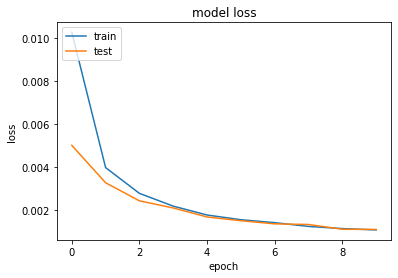

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('./graphics/model_loss.png')
plt.show()

## Function to Check Reconstructed Photos

In [23]:
import matplotlib.pyplot as plt
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))

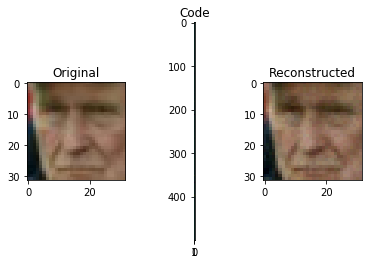

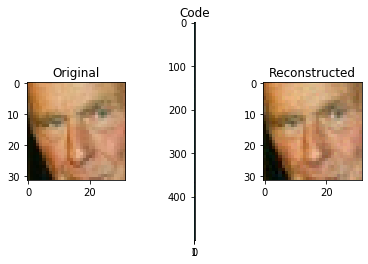

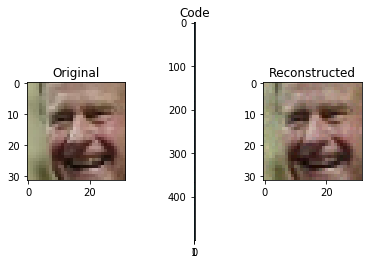

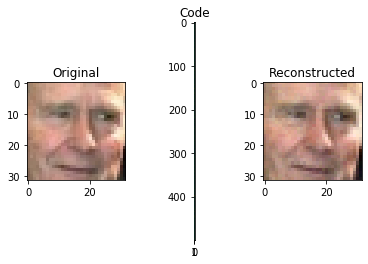

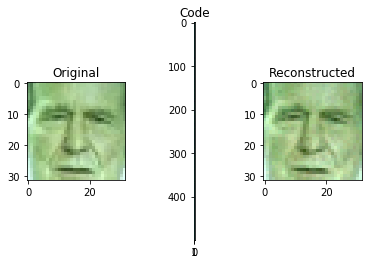

<Figure size 432x288 with 0 Axes>

In [24]:
def visualize(img,encoder,decoder,):
    """Draws original, encoded and decoded images"""
    # img[None] will have shape of (1, 32, 32, 3) which is the same as the model input
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
   
    plt.show()
    plt.savefig('famous{}.png'.format(count))
for i in range(5):
    img = X[i]
    visualize(img,encoder,decoder)

## Function to test the model with friends photos

In [ ]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

In [ ]:
def load_dataset(path):
    img_data_list=[]
    data_path = path

    data_dir_list = os.listdir(data_path)
    for dataset in data_dir_list:
        img_list=os.listdir(data_path+'/'+ dataset)
        print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
        for img in img_list:
            input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
            input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
            #input_img_resize=cv2.resize(input_img,(64,64))
            faces = face_cascade.detectMultiScale(input_img, 1.1, 3)
            print (faces[0])
            #input_img_resize=cv2.resize(input_img,(128,128))
            x,y,w,h = faces[0]
            print(x,y,w,h)
            face = input_img[y:y+h,x:x+w]
            face=cv2.resize(face,(32,32))
            #face=face / 255.0 - 0.5
            #face = np.expand_dims(faces, axis=1)
            img_data_list.append(face)

    img_data = np.stack(img_data_list).astype('uint8')
    #img_data = img_data.astype('float32')
    return img_data/ 255.0 - 0.5

In [ ]:
X = load_dataset("../data/fotop/")
X.shape

In [ ]:
for i in range(5):
    img = X[i]
    visualize(img,encoder,decoder)